![alt-text](https://upload.wikimedia.org/wikipedia/commons/2/22/ENSAE_logo_developpe.jpg)

# Reinforcement Learning Project

In this project, we will try to see if we are able to **teach a simple behaviour to an agent** using a Reinforcement Learning algorithm : Q-Learning.  
[Q-Learning](https://en.wikipedia.org/wiki/Q-learning) is a method that allows an **agent** to learn the **best action** given the **state** where the agent is. The quality (Q) of an action depends on the possible **reward** that can come from chosing that action. Here, we will make up our own agents, **Blobs**, which are colorful bubbles that can move and live in a 2D space called a **Universe**. In this Universe there will be **Food**, and we will try to **teach the Blobs to go eat the food**.  

Let's dive in !

**Some imports**

In [1]:
from warnings import filterwarnings

filterwarnings(action="ignore")  # Ignore some tensorflow warnings

In [2]:
import os
import re
from copy import deepcopy

import pickle
from tqdm import tqdm, tqdm_notebook

# from itertools import combinations
from collections import defaultdict

import numpy as np
from numpy.linalg import norm

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.collections import PatchCollection

from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, Dense, concatenate, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten

plt.rcParams["animation.html"] = "jshtml"

tqdm.monitor_interval = 0

Using TensorFlow backend.


In [3]:
%matplotlib notebook

---

# Objects

**Some default parameters**

In [4]:
VISUAL_SPAN = 10
DEFAULT_BLOB_SIZE = 1
DEFAULT_FOOD_SIZE = 0.2
UNIVERSE_BORDERS = -20, 20, -20, 20

## Base object

First, we define a base object that all the other objects will inherit from.

In [5]:
from abc import ABC, abstractmethod

class BaseObject(ABC):
    """
    Abstract class that defines a basic \"object\".

    ==========
    Arguments:
    ==========
    x, y: float, initial position of the object.
    size: float, size of the object.
    color: one of matplotlib's supported colors, color of the object.
    """
    
    @abstractmethod
    def __init__(self, x, y, size, color):
        
        self.color = color
        self.destroyed = False
        
        # Attributes that may vary
        self.x = x
        self.y = y
        self.size = size
        
        # Initial attributes, used to reset the object
        self.x0 = x
        self.y0 = y
        self.size0 = size


    def reset(self):
        """
        Resets the object to its original state.
        """
        self.destroyed = False
        self.x = self.x0
        self.y = self.y0
        self.size = self.size0


    def get_position(self):
        """
        Gets the current position of the object.
        """
        return np.array([self.x, self.y])

This base object has a **size**, a **position**, a **color** and is either in a **destroyed** state or not.

BaseObject is an abstract class by the way, and can't be instanciated by itself:

In [6]:
try:
    test = BaseObject()
except Exception as e:
    print(e)

Can't instantiate abstract class BaseObject with abstract methods __init__


## Food object

Then we define the **Food** as BaseObjects with some particular parameters : a black color and a size of 0.2

In [7]:
class Food(BaseObject):
    """
    Instanciates a Food object which whole purpose is to be eaten (:sad:).
    
    ==========
    Arguments:
    ==========
    x, y: float, initial position of the object.
    """

    def __init__(self, x, y):
        super().__init__(x, y, size=DEFAULT_FOOD_SIZE, color="black")

We can have a look at the attributes of a Food object:

In [8]:
print("Example of Food:\n================\n")
for attr, value in Food(x=0, y=0).__dict__.items():
    print(f"{attr}: {value}")

Example of Food:

color: black
destroyed: False
x: 0
y: 0
size: 0.2
x0: 0
y0: 0
size0: 0.2


## Blobs

This is where it gets more interesting. Let's define a **Blob** object.  
Blobs are BaseObjects with size 1. They are able to **compute distances** if asked to, and **move** in any particular given direction.

In [9]:
class Blob(BaseObject):
    """
    Instanciates a Blob object that is able to move and eat other objects.
    Eating Food makes the Blob bigger while eating another Blob
    doesn't have any effect.

    ===========
    Arguments :
    ===========
    x, y: float, initial position of the object.
    color: one of matplotlib's supported colors, color of the object.    
    """

    def __init__(self, x, y, color):        
        super().__init__(x, y, size=DEFAULT_BLOB_SIZE, color=color)

        
    def compute_distance_to_obj(self, obj):
        """
        Computes the distance to a given object.
        """
        # Get positions
        obj_pos = obj.get_position()
        self_pos = self.get_position()

        # Compute distance (L2-norm)
        dist = norm(obj_pos - self_pos)
        return dist

    
    def move_towards_obj(self, obj):
        """
        Moves towards a given object.
        """
        # Get positions
        obj_pos = obj.get_position()
        self_pos = self.get_position()
        
        # Compute direction
        direction = obj_pos - self_pos

        # Compute step of size 1 in this direction (L2-norm)
        dx, dy = np.asarray(direction) / norm(direction)
        
        # Move
        self.x += dx
        self.y += dy


    def move(self, dx, dy):
        """
        Moves in a given direction.
        """
        self.x += dx
        self.y += dy


    def get_closest(self, objects):
        """
        Detects and returns the closest object from the provided list of objects.
        """
        closest_obj = None
        closest_obj_distance = np.inf
        
        # For each object
        for obj in objects:
            
            # Compute distance
            distance = self.compute_distance_to_obj(obj)

            # Check if object is closer than previous ones
            if distance < closest_obj_distance:
                closest_obj = obj
                closest_obj_distance = distance

        return closest_obj

## Universe

Now the **Universe**. Universes are the 2D spaces where Blobs can live.  
We can create a universe from a list of Blobs and Foods. Then we can run simulations to study the Blob's behaviour.

In [14]:
class BaseUniverse(ABC):
    """
    Base Universe object where objects can live,
    but that is unable to run any simulations.

    ===========
    Arguments :
    ===========
    blobs: list of Blobs.
    food: list of Foods.
    
    """

    xmin, xmax, ymin, ymax = UNIVERSE_BORDERS

    @abstractmethod
    def __init__(self, blobs, foods, max_steps):

        self.step = 0
        self.max_steps = max_steps

        self.blobs = blobs
        self.foods = foods
        
        self.objects = blobs + foods


    def reset(self):
        """
        Resets the Universe to its original state.
        """
        self.step = 0
        for obj in self.objects:
            obj.reset()
        

    def simulate(self, move=None):
        raise NotImplementedError

                    
    def animate(self):
        """
        Simulates a single step then plots the universe in its current state.
        """

        # Clear the figure
        plt.cla()

        # Show the title
        self.ax.set_title("Universe")

        # Limit the plot to the Universe's borders
        self.ax.axis([self.xmin-1, self.xmax+1, self.ymin-1, self.ymax+1])

        # Simulate a single step
        self.simulate()

        # Draw each object that is not destroyed
        patches = []
        for obj in self.objects:
            if not obj.destroyed:
                patch = self.ax.add_patch(
                    plt.Circle(
                        xy=(obj.x, obj.y),
                        radius=obj.size,
                        color=obj.color,
                        alpha=0.4 if isinstance(obj, Blob) else 1
                    )
                )
                
                patches.append(patch)
                
        return PatchCollection(patches)
    
    
    def simulate_and_animate(self):
        """
        Simulates a given number of steps and creates an animation.
        """

        # Parameters of the Figure where the animation is shown
        self.fig = plt.figure(figsize=(9, 5))
        self.ax = self.fig.add_subplot(111, aspect='equal')
        
        # Simulate and plot n steps
        animation = FuncAnimation(self.fig, lambda step: self.animate(),
                                  frames=self.max_steps, repeat=False)

        return animation

---
# Part I : Ideal setting

Now that we've defined every object we need, let's run an **ideal** simulation where the Blobs know how to **look for the closest Food and eat it**.  
For that we quickly change the simulation step:

In [15]:
class IdealUniverse(BaseUniverse):
    """
    Creates an Ideal Universe where every Blob
    knows instinctively how to look for the closest food.

    ===========
    Arguments :
    ===========
    blobs: list of Blobs.
    food: list of Foods.
    """

    def __init__(self, blobs, foods, max_steps=100):
        super().__init__(blobs, foods, max_steps)        


    def simulate(self):
        """
        Simulates a single step. A step consists in moving then
        eating the closest available food if it is close enough.
        """
        
        self.step += 1
        
        # For each Blob
        for obj in self.blobs:

            # Look for closest food
            available_food = [food for food in self.foods if not food.destroyed]
            closest_food = obj.get_closest(available_food)
            search_result = (closest_food is not None)

            # If any
            if search_result:

                # Move towards the food
                obj.move_towards_obj(closest_food)
                
                # If close enough, eat it & grow
                distance = obj.compute_distance_to_obj(closest_food)
                if distance < 1:
                    closest_food.destroyed = True
                    obj.size += 1

We will create a universe with 5 Blobs and 20 randomly positioned Food objects, then simulate 100 steps:

In [16]:
def gen_random_position():
    return np.random.randint(-20, 21), np.random.randint(-20, 21)

<IPython.core.display.Javascript object>


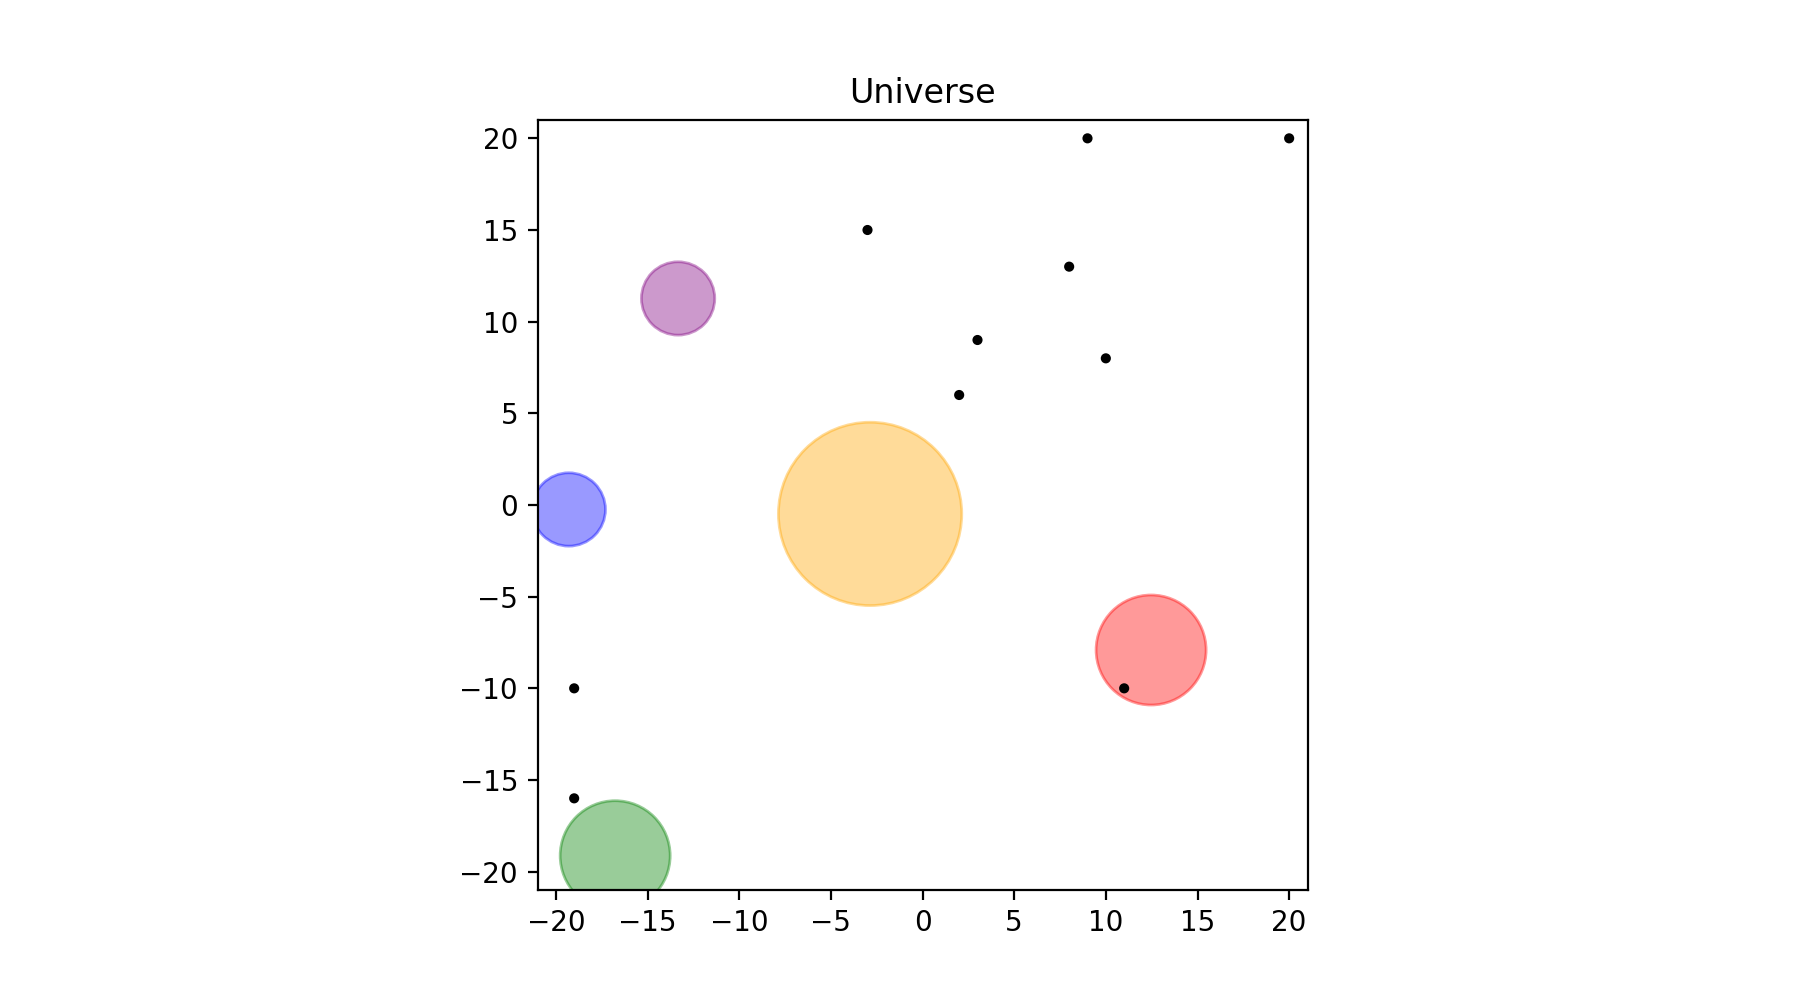

In [17]:
blobs = [
    Blob(*gen_random_position(), color="red"),
    Blob(*gen_random_position(), color="green"),
    Blob(*gen_random_position(), color="blue"),
    Blob(*gen_random_position(), color="purple"),
    Blob(*gen_random_position(), color="orange")
]

foods = [Food(*gen_random_position()) for _ in range(20)]

universe = IdealUniverse(blobs=blobs, foods=foods)
universe.reset()
_ = universe.simulate_and_animate()

We can check the sizes of the blobs after our simulation:

In [18]:
print("Blob sizes:\n===========\n")
for b in blobs:
    print(f"{b.color}\t: {b.size}")

Blob sizes:

red	: 3
green	: 3
blue	: 2
purple	: 2
orange	: 5


---
# Part II : Learning the behaviour

It is nice to see that we can **hard-code** the desired behaviour and watch our blobs race for food. But what would be really interesting is to see if we can **teach** a Blob to look for the closest food and eat it simply **through trial and error**. Q-learning does just that.  

Starting with a **state** of the Universe that we have yet to define, we can use a **Q-learning model** to let a Blob **predict** which direction to choose to eventually reach food. At first, these choices will be **random**. But whenever the Blob does in fact **stumble upon** a Food object, we will update the model to make it **remember** how it got there. Then, by running a **large number** of simulations, and if the model is **good enough**, the Blob will have **learned** how to move towards food.

In [19]:
class QLearningUniverse(BaseUniverse):
    """
    Creates a Universe where Blobs learn how to
    look for the closest food using Q-Learning.

    ===========
    Arguments :
    ===========
    blobs: list of Blobs.
    food: list of Foods.
    """

    def __init__(self, blobs, foods, max_steps=100):
        super().__init__(blobs, foods, max_steps)        



    def simulate(self, move):
        """
        Simulates a single step. A step consists in moving in
        the provided direction then eating the closest available
        food if it is close enough.
        """

        self.step += 1
        
        # For each Blob
        for obj in self.blobs:
            
            # Move toward given coordinates
            obj.move(*move)

            # Look for closest food
            available_food = [food for food in self.foods if not food.destroyed]
            closest_food = obj.get_closest(available_food)
            search_result = (closest_food is not None)

            if search_result:
                
                # If close enough, eat it & grow
                distance = obj.compute_distance_to_obj(closest_food)
                if distance < 1: # obj.size:
                    closest_food.destroyed = True
                    obj.size += 1

            # Make sure the blob is always in the universe
            if (obj.x < self.xmin) or obj.x > self.xmax:
                obj.x *= -1
            elif (obj.y < self.ymin) or obj.y > self.ymax:
                obj.y *= -1


    def get_state(self):
        """
        Gets the state of the universe as a square image
        around the blob. This is used with only one Blob
        to train models using Q-learning.
        """
        span = VISUAL_SPAN
        neighbourhood = np.zeros((2 * span + 1, 2 * span + 1))

        blob = self.blobs[0]
        blob_pos = blob.get_position()
        for f in self.foods:
            if not f.destroyed:
                food_pos = f.get_position()        
                condition = (food_pos[0] <= (blob_pos[0] + span)) * (food_pos[0] >= (blob_pos[0] - span))
                condition *= (food_pos[1] <= (blob_pos[1] + span)) * (food_pos[1] >= (blob_pos[1] - span))
                if condition:
                    shifted_pos = (food_pos - blob_pos).astype(int) + span

                    i_value = 2 * span - shifted_pos[1]
                    j_value = shifted_pos[0]
                    neighbourhood[i_value, j_value] = 1
        
        return neighbourhood.reshape(1, *neighbourhood.shape, 1)


    def animate(self, model):
        """
        Simulates a single step then plots the universe in its current state.
        """

        # Clear the figure
        plt.cla()

        # Show the title
        self.ax.set_title("Universe")

        # Limit the plot to the Universe's borders
        self.ax.axis([self.xmin-1, self.xmax+1, self.ymin-1, self.ymax+1])

        # Simulate a single step
        s = self.get_state()            

        pred = model.predict(s).ravel()
        angle = np.argmax(pred) * 2 * np.pi / len(pred)
            
        self.simulate(move=(np.cos(angle), np.sin(angle)))

        # Draw each object that is not destroyed
        patches = []
        for obj in self.objects:
            if not obj.destroyed:
                patch = self.ax.add_patch(
                    plt.Circle(
                        xy=(obj.x, obj.y),
                        radius=obj.size,
                        color=obj.color,
                        alpha=0.4 if isinstance(obj, Blob) else 1
                    )
                )
                
                patches.append(patch)
                
                # plot visual ranges for blobs
                if isinstance(obj, Blob):
                    patch = self.ax.add_patch(
                        plt.Rectangle(
                            xy=(obj.x - VISUAL_SPAN, obj.y - VISUAL_SPAN),
                            height=2 * SPAN, width=2 * SPAN,
                            color=obj.color, fill=False,
                            alpha=0.4
                        )
                    )
                    patches.append(patch)
                
        return PatchCollection(patches)
    

    def simulate_and_animate(self, model):
        """
        Simulates a given number of steps and creates an animation.
        """

        # Parameters of the Figure where the animation is shown
        self.fig = plt.figure(figsize=(9, 5))
        self.ax = self.fig.add_subplot(111, aspect='equal')
        
        # Simulate and plot n steps
        animation = FuncAnimation(self.fig, lambda step: self.animate(model),
                                  frames=self.max_steps, repeat=False)

        return animation

The class above defines a Universe where blobs use a provided Q-Learning model as a basis to move and look for food.
The **state** that is used to learn this behaviour is a **20x20 square image around the position of the Blob** where all pixels are black but the ones where food is that are white.

In [20]:
blobs = [Blob(*gen_random_position(), color="red")]
foods = [Food(*gen_random_position()) for _ in range(20)]
universe = QLearningUniverse(blobs=blobs, foods=foods)

In [21]:
span = VISUAL_SPAN
neighbourhood = np.zeros((2 * span + 1, 2 * span + 1))

blob = universe.blobs[0]
blob_pos = blob.get_position()
for f in universe.foods:
    if not f.destroyed:
        food_pos = f.get_position()        
        condition = (food_pos[0] <= (blob_pos[0] + span)) * (food_pos[0] >= (blob_pos[0] - span))
        condition *= (food_pos[1] <= (blob_pos[1] + span)) * (food_pos[1] >= (blob_pos[1] - span))
        if condition:
            shifted_pos = (food_pos - blob_pos).astype(int) + span
            
            i_value = 2 * span - shifted_pos[1]
            j_value = shifted_pos[0]
            neighbourhood[i_value, j_value] = 1

<IPython.core.display.Javascript object>


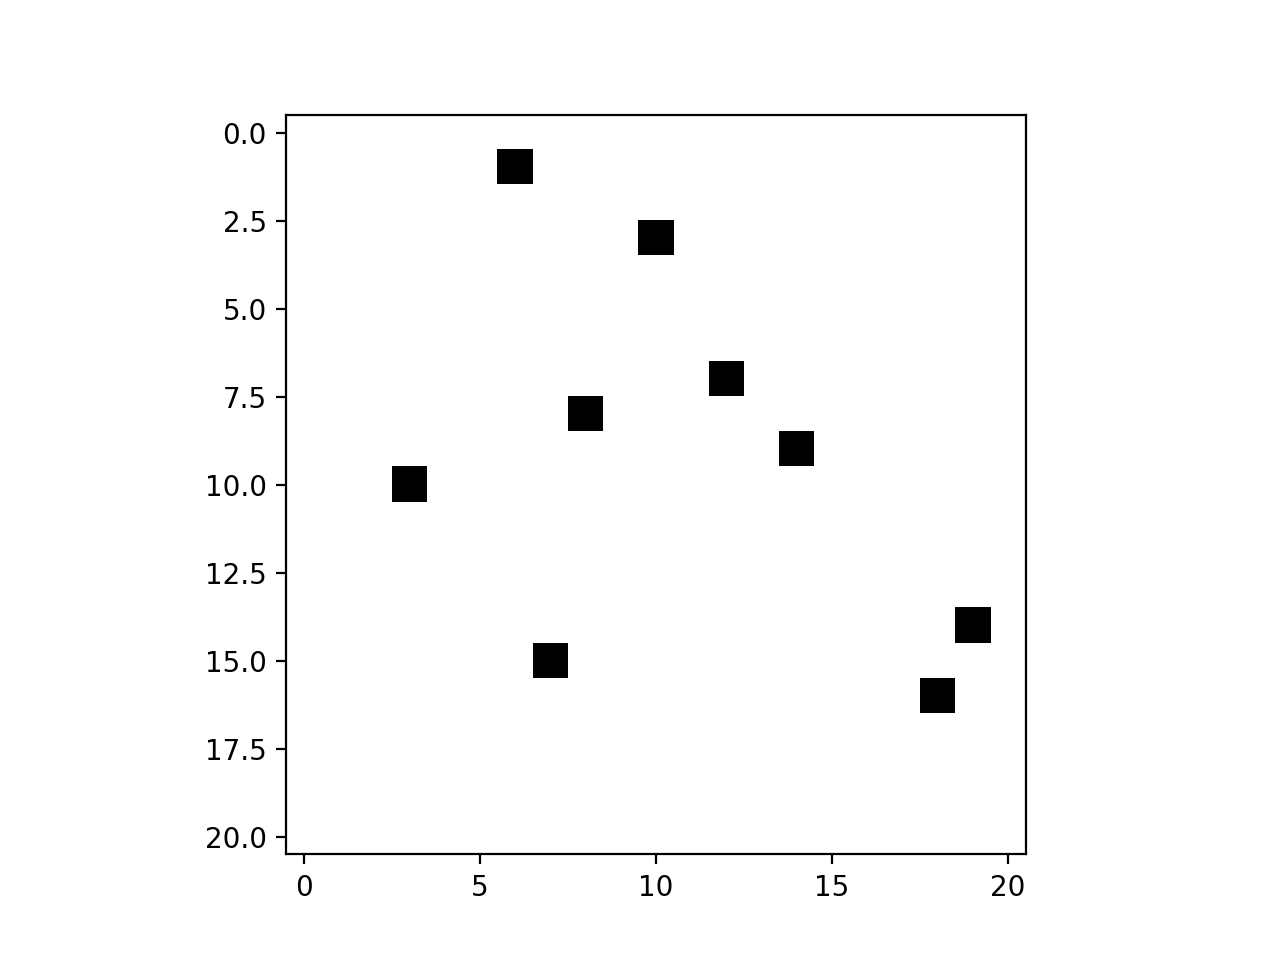

In [22]:
plt.figure()
plt.imshow(neighbourhood, cmap='Greys')
plt.show()

## Model Training

The model we will be using will have to be able to **process an image** and produce a **vector of size 4**. The idea is that this vector will represent the **predicted rewards for each basic direction (right, up, left, down)** in this order. A reward is either **0 if no food was found** in a particular step or **1 if food was found**. The value the model will try to learn is the anticipated reward, i.e. the **real reward for a step + the best possible reward from that new position**.  
(More about the algorithm at https://en.wikipedia.org/wiki/Q-learning#Algorithm)

We choose to train a Convolutional Neural Network as these work well on images :

In [23]:
n_directions = 4  # right, up, left, down

model_name = f"CNN"

input_img = Input(shape=(2 * VISUAL_SPAN + 1, 2 * VISUAL_SPAN + 1, 1))

x = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_img)
x = Conv2D(64, (3, 3), activation='relu')(x)

x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
    
x = Dense(128, activation='sigmoid')(x)
    
directions = Dense(n_directions, activation="linear")(x)

model = Model(inputs=input_img, outputs=directions)
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 21, 21, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 19, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               524416    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 516       
Total para

Then we need our actual Q-Learning training loop:

In [ ]:
########################
###### Parameters ######
########################

n_foods = 20

exploration_rate = 0.5
decay_factor = .998  # such that 0.5 * (0.998) ** 1000 = 5%

n_different_universes = 10
n_episodes = 1000

future_reward_discount_factor = 0.95


###########################
###### Training Loop ######
###########################

# Create model folders if doesnt exist
if not os.path.exists("models"):
    os.makedirs("models")


avg_score_per_universe = []
avg_loss_per_universe = []

# Simulate 10 different Universes
for universe_number in tqdm_notebook(range(n_different_universes), desc="universe"):

    universe_model_name = "{}_universe_{}".format(model_name, universe_number + 1)
    universe_model_name = os.path.join("models", universe_model_name)

    exploration_proba = exploration_rate

    # New Universe
    blobs = [Blob(*gen_random_position(), color="red")]
    foods = [Food(*gen_random_position()) for _ in range(n_foods)]
    universe = QLearningUniverse(blobs=blobs, foods=foods)

    # Run 1000 simulations
    score_per_episode = []
    avg_loss_per_episode = []
    for episode in tqdm_notebook(range(n_episodes), desc="episode"):

        losses = []
        exploration_proba *= decay_factor
        
        # Reset universe to initial state
        universe.reset()
        s = universe.get_state()

        # While not end of simulation
        done = False
        while not done:

            # Choose best direction with possible random move
            if np.random.random() < exploration_proba:
                a = np.random.randint(0, n_directions)
            else:
                pred = model.predict(s)
                a = np.argmax(pred.ravel())

            # Blob size before step
            previous_size = blobs[0].size

            # Simulate a single step
            universe.simulate(move=(np.cos(a*np.pi/2), np.sin(a*np.pi/2)))

            # Compute mmediate reward
            r = blobs[0].size - previous_size

            # Check if last iteration
            done = universe.step == universe.max_steps

            # Compute the maximum future reward
            next_s = universe.get_state()
            next_r = np.max(model.predict(next_s))

            # Compute anticipated reward
            target = r + future_reward_discount_factor * next_r
            target_vec = model.predict(s).ravel()
            target_vec[a] = target

            # Train model
            history = model.fit(s, target_vec.reshape(1, -1), epochs=1, verbose=0)
            losses.append(history.history["loss"][0])

            # Update state
            s = next_s

        # Save score and loss
        score_per_episode.append(blobs[0].size - DEFAULT_BLOB_SIZE)
        avg_loss_per_episode.append(np.mean(losses))

    # Save one model per universe
    model.save("{}.h5".format(universe_model_name))

    # Save score and loss evolution
    pickle.dump(score_per_episode, open("{}_score_per_episode".format(universe_model_name), "wb"))
    avg_score_per_universe.append(np.mean(score_per_episode))

    pickle.dump(avg_loss_per_episode, open("{}_avg_loss_per_episode".format(universe_model_name), "wb"))
    avg_loss_per_universe.append(np.mean(avg_loss_per_episode))

## Pre-trained models

Model training can take a long time, but we have already trained some models. Here they are:

In [24]:
models = {}
complete_scores = []
complete_losses = []
for i in range(1, 11):
    scores = pickle.load(open(f"models/CNN_span-10_universe_{i}_score_per_episode", "rb"))
    complete_scores += scores
    losses = pickle.load(open(f"models/CNN_span-10_universe_{i}_avg_loss_per_episode", "rb"))
    complete_losses += losses
    models[i] = load_model(f"models/CNN_span-10_universe_{i}.h5")

<IPython.core.display.Javascript object>


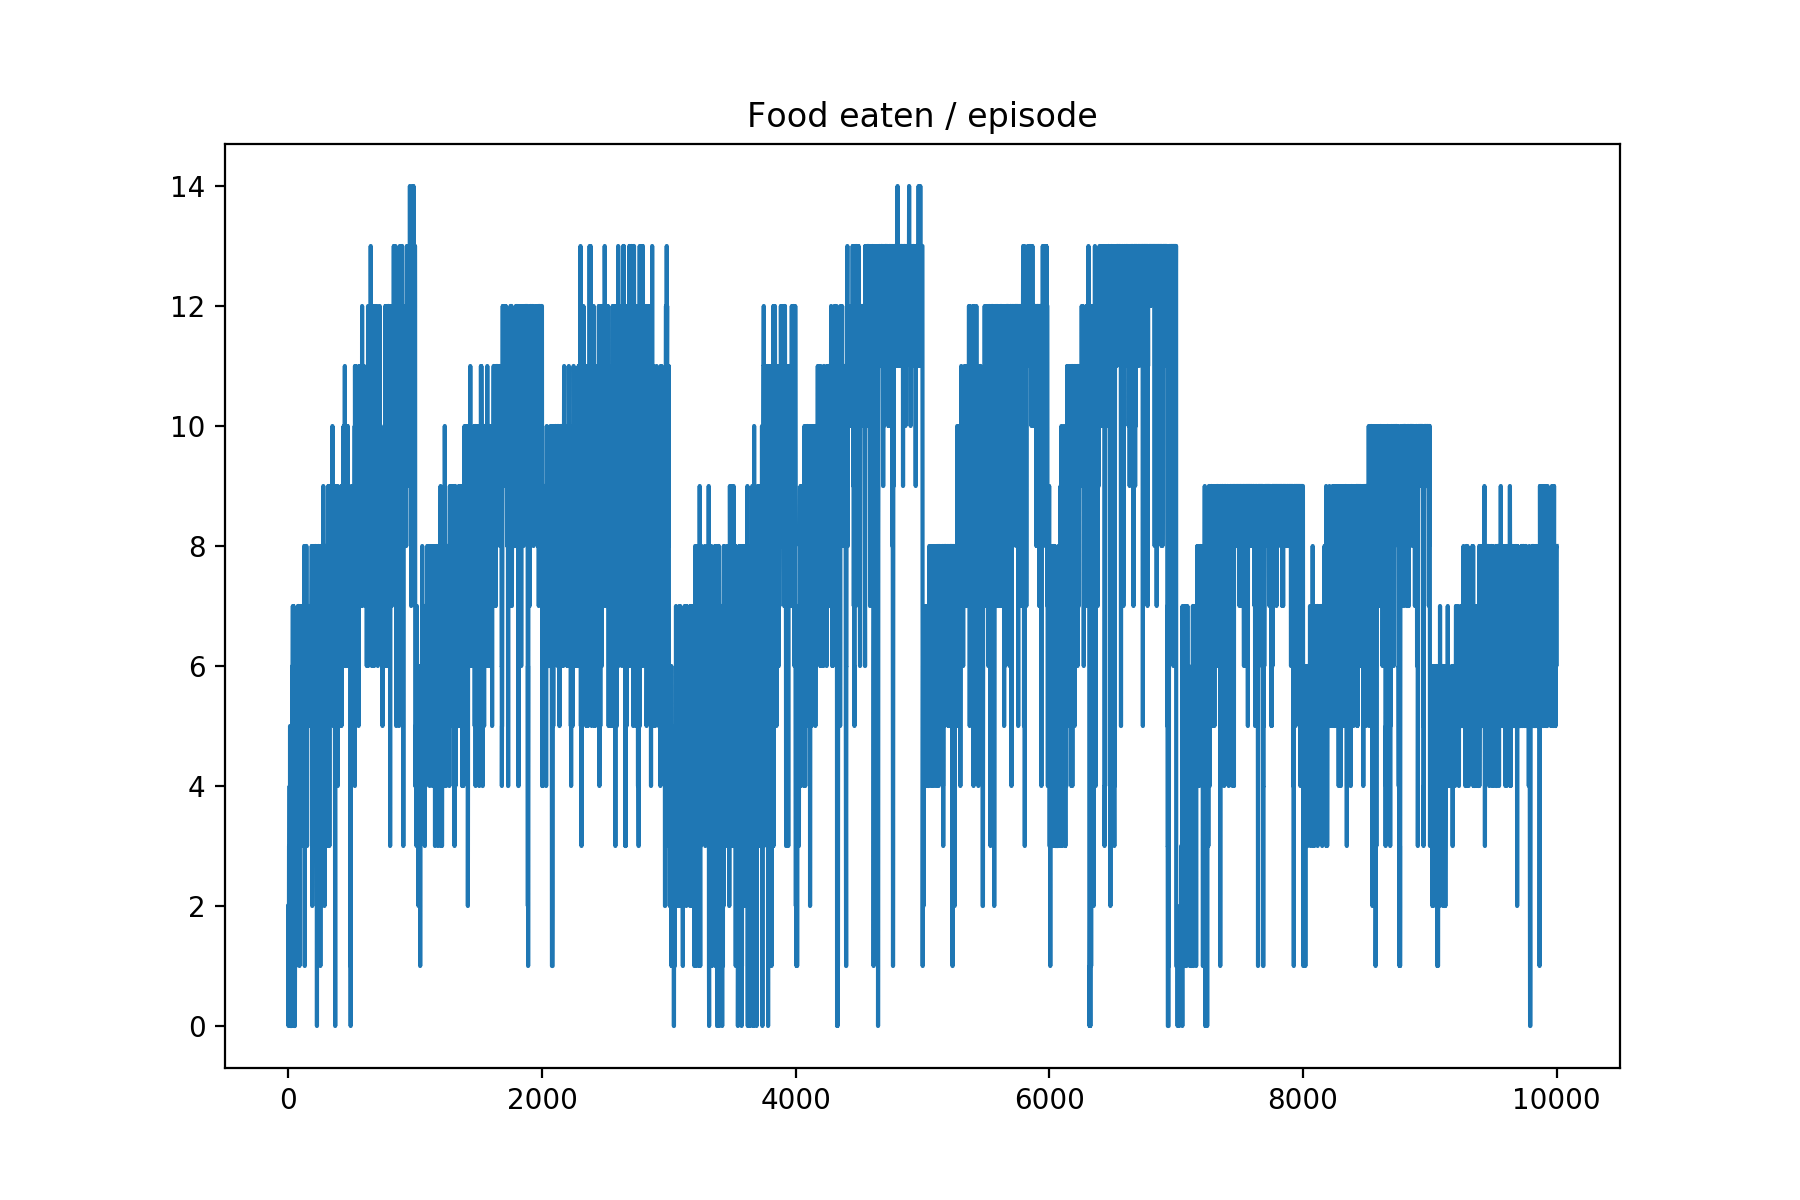

<IPython.core.display.Javascript object>


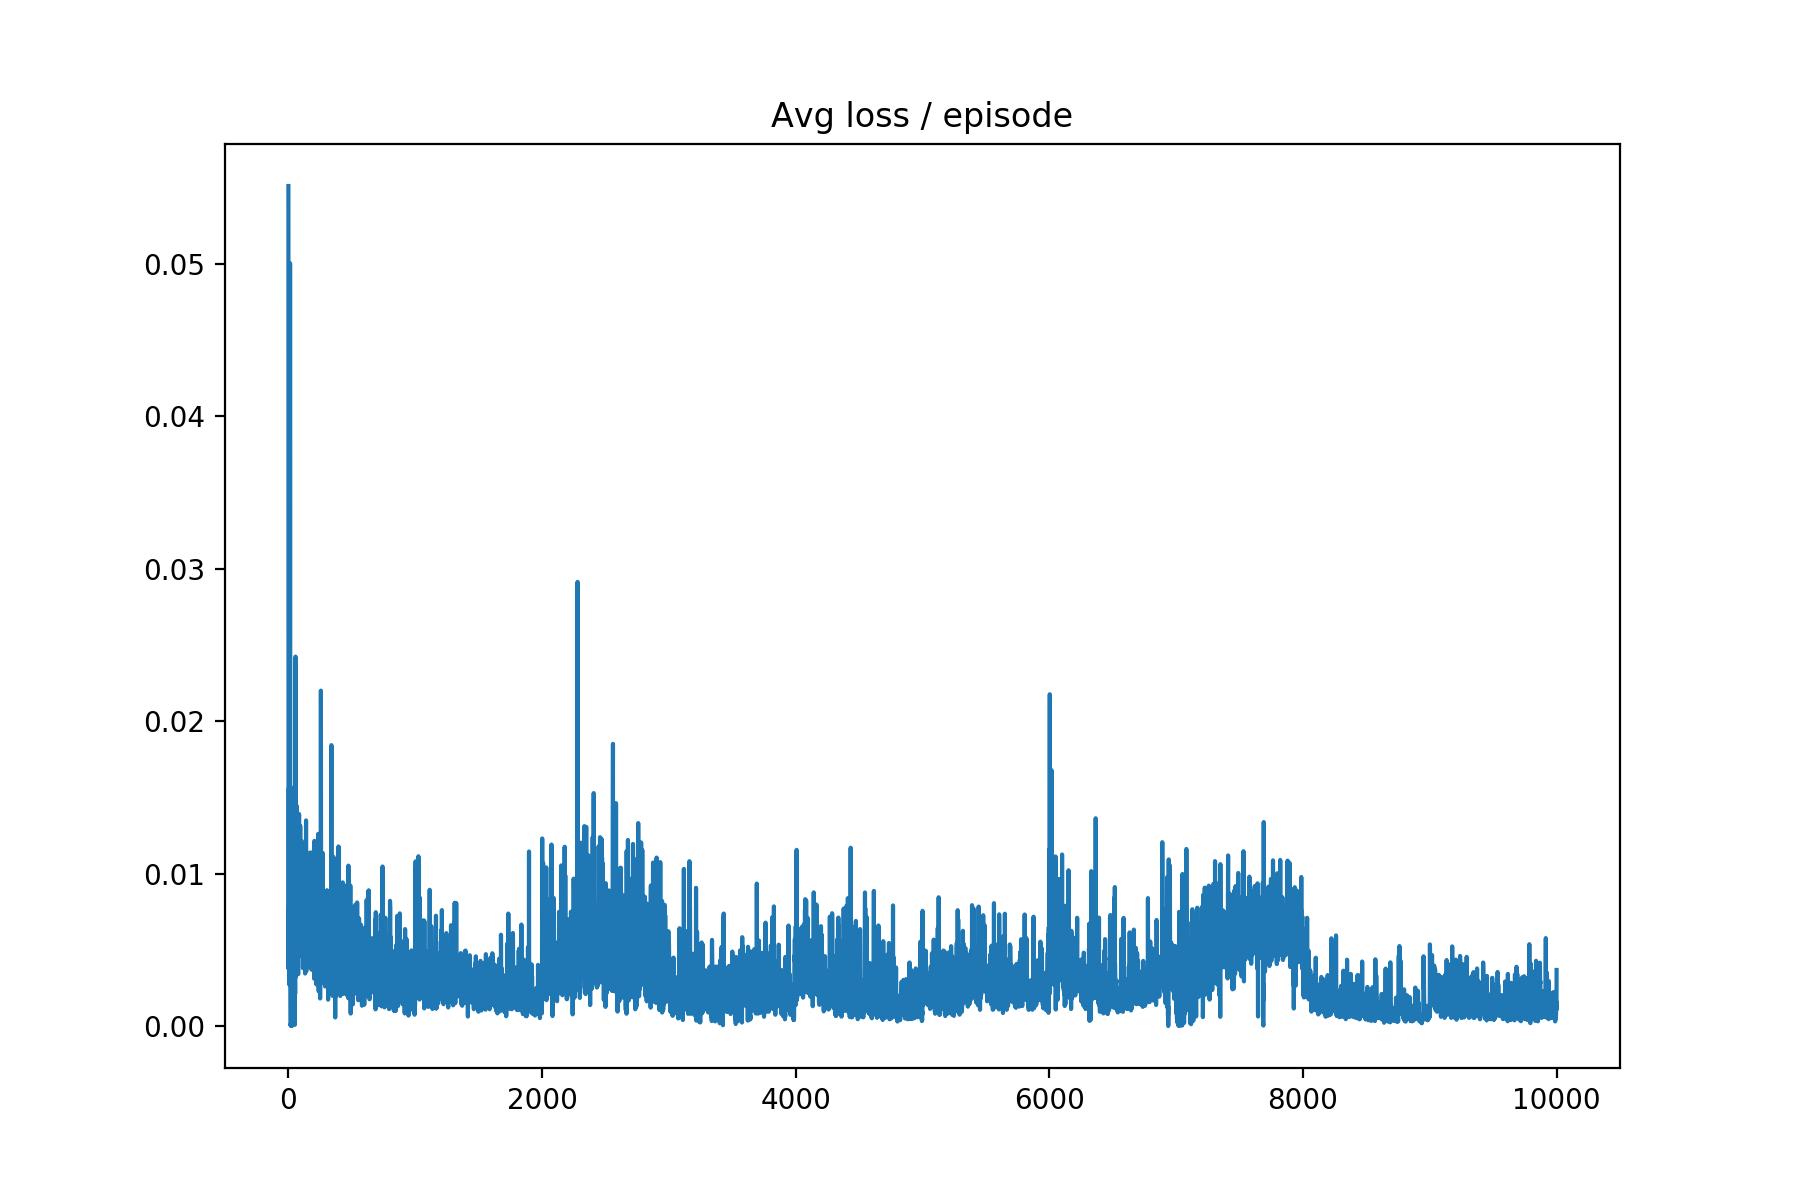

In [25]:
plt.figure(figsize=(9, 6))
plt.title("Food eaten / episode")
plt.plot(complete_scores)

plt.figure(figsize=(9, 6))
plt.title("Avg loss / episode")
plt.plot(complete_losses)

plt.show()

We can see that the trained Blob is often able to eat food. So let's check this in animation:

In [27]:
model = models[5]
SPAN = (model.layers[0].input_shape[1] - 1)//2
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 21, 21, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 19, 19, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 17, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               524416    
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 516       
Total para

In [28]:
blobs = [Blob(*gen_random_position(), color="red")]
foods = [Food(*gen_random_position()) for _ in range(20)]
universe = QLearningUniverse(blobs=blobs, foods=foods)

<IPython.core.display.Javascript object>


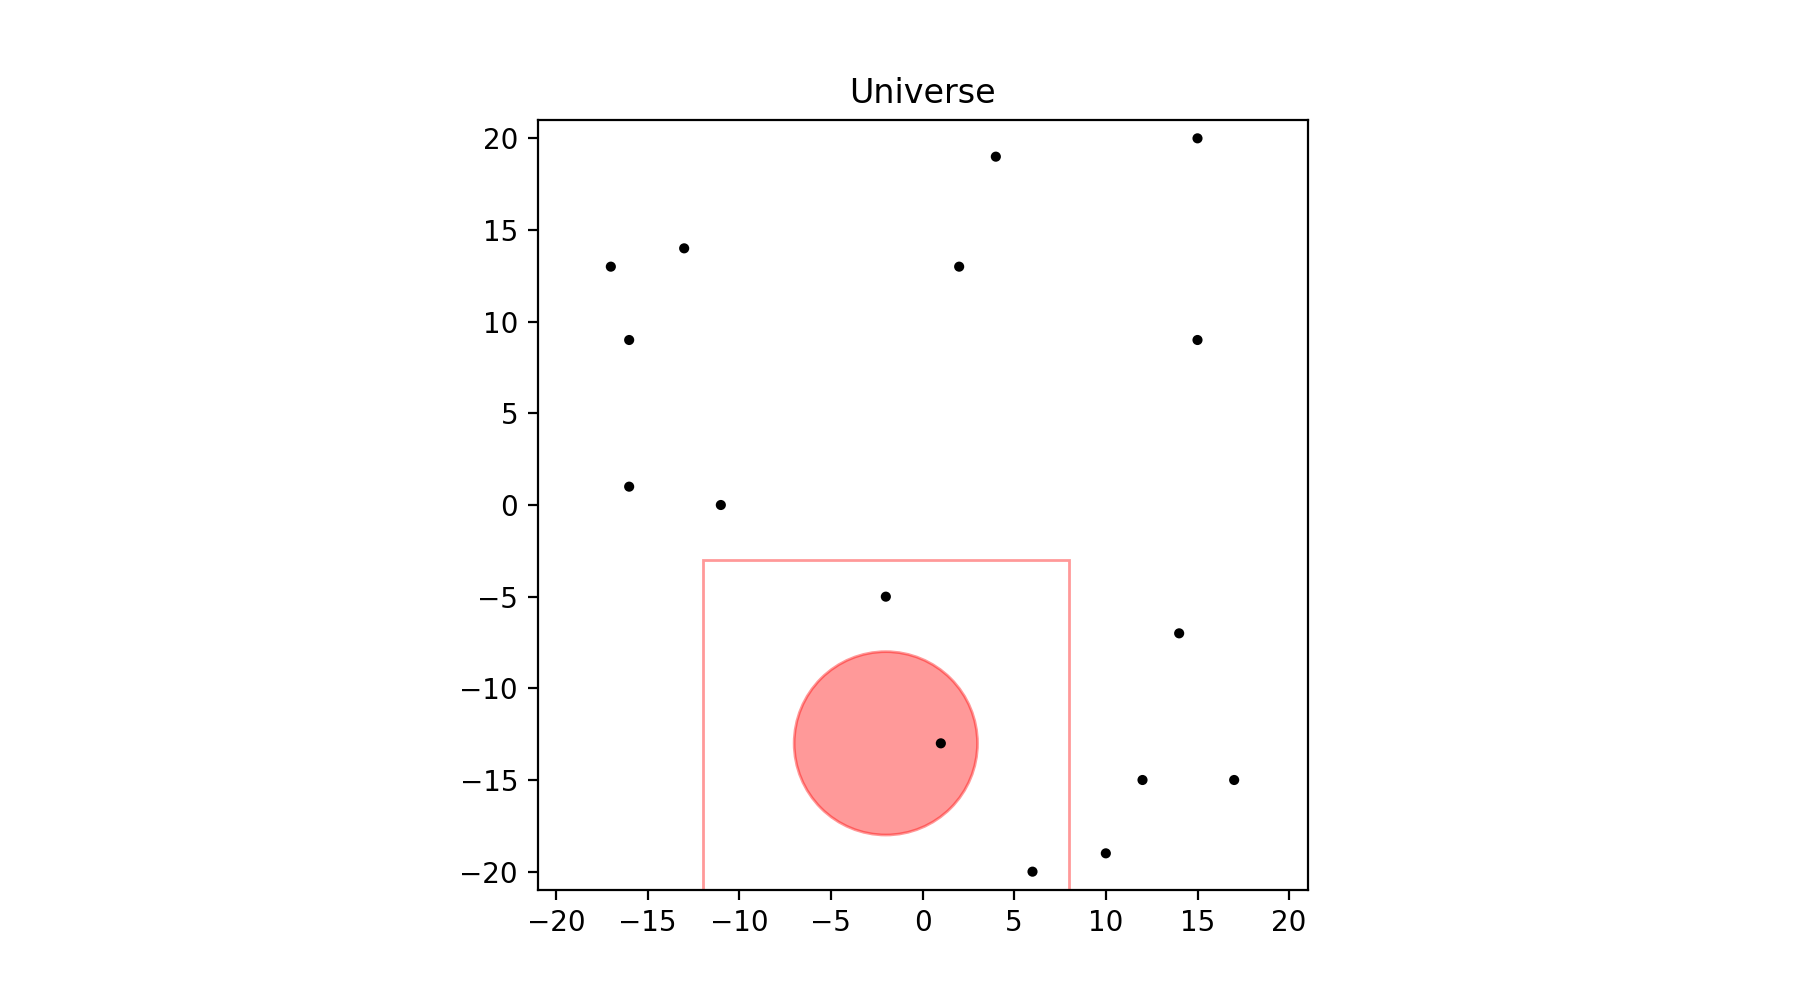

In [29]:
universe.reset()
_ = universe.simulate_and_animate(model=model)

___

# Final Showdown

In [30]:
class Universe(BaseUniverse):
    """
    Creates a Universe where Blobs race for food.

    ===========
    Arguments :
    ===========
    blobs: list of Blobs.
    food: list of Foods.
    """

    def __init__(self, blobs, foods, max_steps=100):
        super().__init__(blobs, foods, max_steps)        


    def simulate(self):
        """
        Simulates a single step. A step consists in moving in
        the provided direction then eating the closest available
        food if it is close enough.
        """

        self.step += 1
        
        # For each Blob
        for obj in self.blobs:
            
            # Predict best move
            s = self.get_state(obj)            
            pred = obj.model.predict(s).ravel()
            angle = np.argmax(pred) * 2 * np.pi / len(pred)

            move = (np.cos(angle), np.sin(angle))
            
            # Move toward given coordinates
            obj.move(*move)

            # Look for closest food
            available_food = [food for food in self.foods if not food.destroyed]
            closest_food = obj.get_closest(available_food)
            search_result = (closest_food is not None)

            if search_result:
                
                # If close enough, eat it & grow
                distance = obj.compute_distance_to_obj(closest_food)
                if distance < 1: # obj.size:
                    closest_food.destroyed = True
                    obj.size += 1

            # Make sure the blob is always in the universe
            if (obj.x < self.xmin) or obj.x > self.xmax:
                obj.x *= -1
            elif (obj.y < self.ymin) or obj.y > self.ymax:
                obj.y *= -1


    def get_state(self, blob):
        """
        Gets the state of the universe as a square image
        around the blob. This is used with only one Blob
        to train models using Q-learning.
        """
        span = VISUAL_SPAN
        neighbourhood = np.zeros((2 * span + 1, 2 * span + 1))

        blob_pos = blob.get_position()
        for f in self.foods:
            if not f.destroyed:
                food_pos = f.get_position()        
                condition = (food_pos[0] <= (blob_pos[0] + span)) * (food_pos[0] >= (blob_pos[0] - span))
                condition *= (food_pos[1] <= (blob_pos[1] + span)) * (food_pos[1] >= (blob_pos[1] - span))
                if condition:
                    shifted_pos = (food_pos - blob_pos).astype(int) + span

                    i_value = 2 * span - shifted_pos[1]
                    j_value = shifted_pos[0]
                    neighbourhood[i_value, j_value] = 1
        
        return neighbourhood.reshape(1, *neighbourhood.shape, 1)


    def animate(self):
        """
        Simulates a single step then plots the universe in its current state.
        """

        # Clear the figure
        plt.cla()

        # Show the title
        self.ax.set_title("Universe")

        # Limit the plot to the Universe's borders
        self.ax.axis([self.xmin-1, self.xmax+1, self.ymin-1, self.ymax+1])

        # Simulate a single step
        self.simulate()

        # Draw each object that is not destroyed
        patches = []
        for obj in self.objects:
            if not obj.destroyed:
                patch = self.ax.add_patch(
                    plt.Circle(
                        xy=(obj.x, obj.y),
                        radius=obj.size,
                        color=obj.color,
                        alpha=0.4 if isinstance(obj, Blob) else 1
                    )
                )
                
                patches.append(patch)
                
                # plot visual ranges for blobs
                if isinstance(obj, Blob):
                    patch = self.ax.add_patch(
                        plt.Rectangle(
                            xy=(obj.x - VISUAL_SPAN, obj.y - VISUAL_SPAN),
                            height=2 * SPAN, width=2 * SPAN,
                            color=obj.color, fill=False,
                            alpha=0.4
                        )
                    )
                    patches.append(patch)
                
        return PatchCollection(patches)
    

    def simulate_and_animate(self):
        """
        Simulates a given number of steps and creates an animation.
        """

        # Parameters of the Figure where the animation is shown
        self.fig = plt.figure(figsize=(9, 5))
        self.ax = self.fig.add_subplot(111, aspect='equal')
        
        # Simulate and plot n steps
        animation = FuncAnimation(self.fig, lambda step: self.animate(),
                                  frames=self.max_steps, repeat=False)

        return animation

In [31]:
blobs = [
    Blob(*gen_random_position(), color="red"),
    Blob(*gen_random_position(), color="green"),
    Blob(*gen_random_position(), color="blue"),
    Blob(*gen_random_position(), color="purple"),
    Blob(*gen_random_position(), color="orange")
]

for i, blob in enumerate(blobs):
    blob.model = models[2*i + 1]

foods = [Food(*gen_random_position()) for _ in range(20)]

universe = Universe(blobs=blobs, foods=foods)

<IPython.core.display.Javascript object>


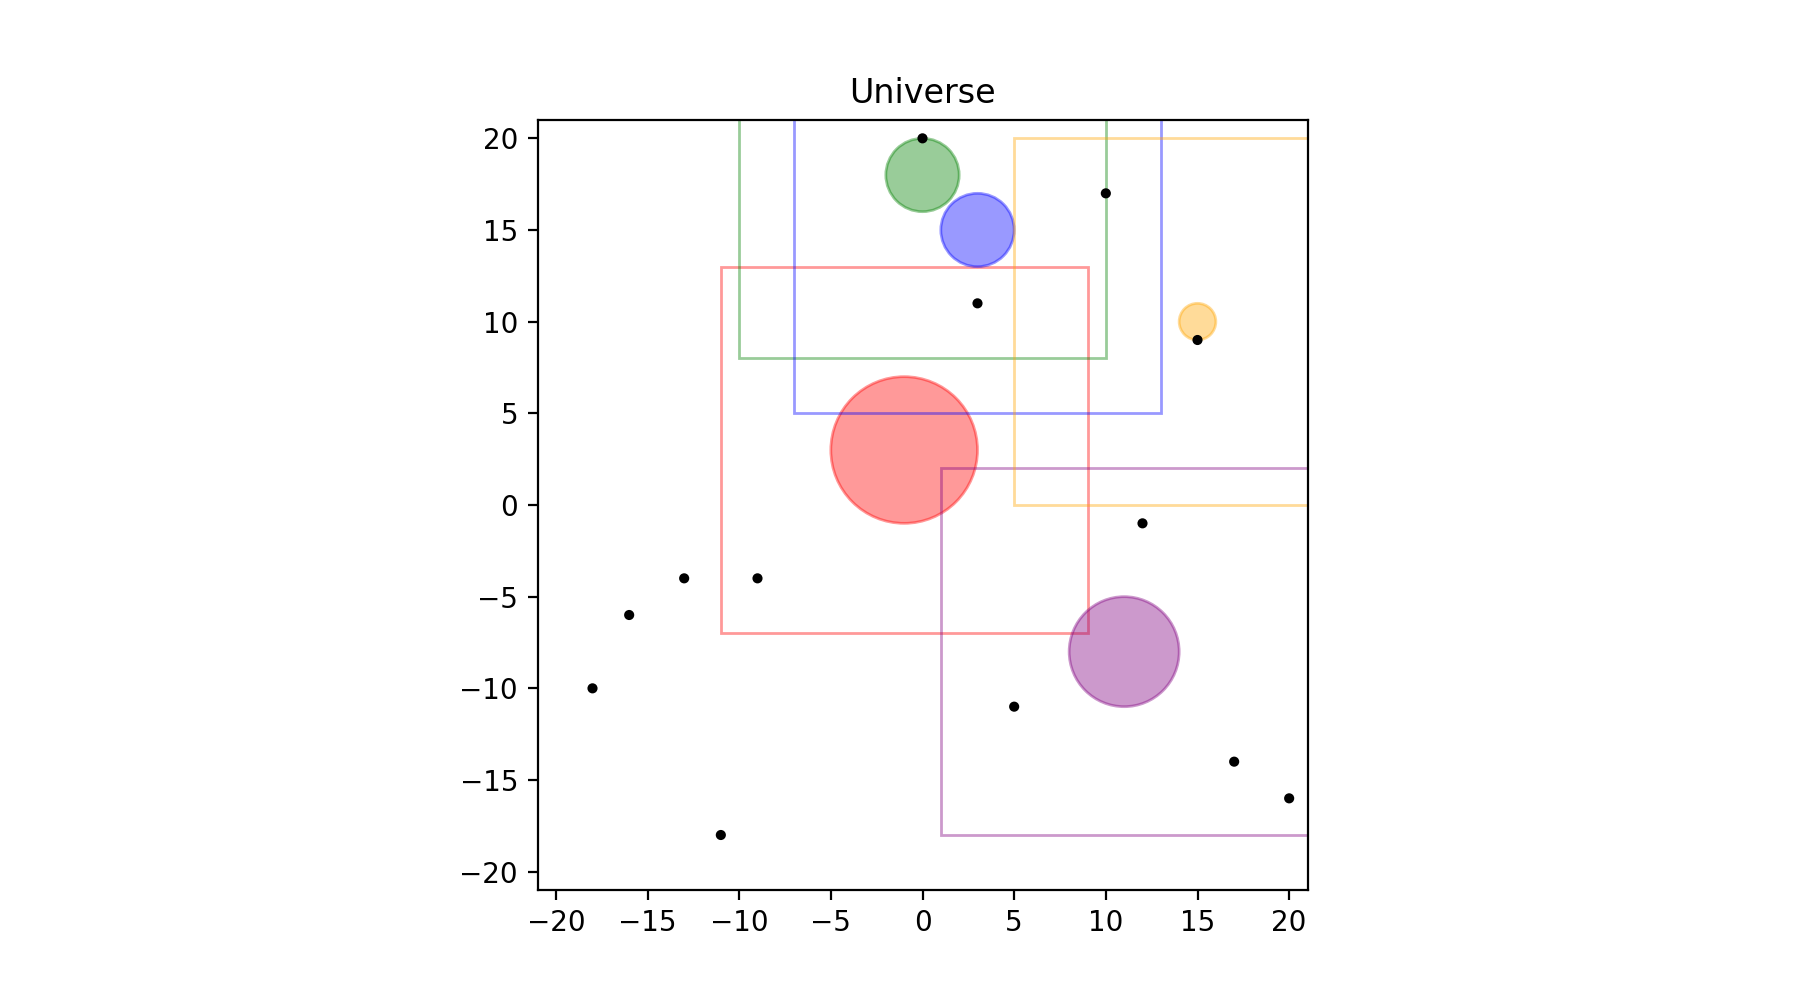

In [32]:
# universe.reset()
_ = universe.simulate_and_animate()

# Bonus

We can take an example state and see what the CNN makes of it:

In [81]:
def plot_activations(input_img_data):
    
    def deprocess_image(x):
        # normalize tensor: center on 0., ensure std is 0.1
        x -= x.mean()
        x /= (x.std() + K.epsilon())
        x *= 0.1

        # clip to [0, 1]
        x += 0.5
        x = np.clip(x, 0, 1)

        # convert to RGB array
        x *= 255
        x = np.clip(x, 0, 255).astype('uint8')

        return x

    layer_dict = dict(
        [(layer.name, layer) for layer in model.layers[1:]
         if isinstance(layer, Conv2D)]
    )
    
    iii=0
    for layer in layer_dict.values():
        iii += 1
        if iii == 1:
            continue
        print(layer.name)

        # this is the placeholder for the input images
        input_img = model.input

        def normalize(x):
            # utility function to normalize a tensor by its L2 norm
            return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


        kept_filters = []
        for filter_index in tqdm_notebook(range(layer.output_shape[-1])):

            # we build a loss function that maximizes the activation
            # of the nth filter of the layer considered
            layer_output = layer.output
            loss = K.mean(layer_output[:, :, :, filter_index])

            # we compute the gradient of the input picture wrt this loss
            grads = K.gradients(loss, input_img)[0]

            # normalization trick: we normalize the gradient
            grads = normalize(grads)

            # this function returns the loss and grads given the input picture
            iterate = K.function([input_img], [loss, grads])

            # step size for gradient ascent
            step = 1.

            # we run gradient ascent for 20 steps
            for i in range(100):
                loss_value, grads_value = iterate([input_img_data])
                input_img_data += grads_value * step

                #print('Current loss value:', loss_value)
                if loss_value <= 0.:
                    # some filters get stuck to 0, we can skip them
                    break

            # decode the resulting input image
            #if loss_value > 0:
            img = deprocess_image(input_img_data[0])
            kept_filters.append((img, loss_value))
        
        _, axs = plt.subplots(8, 8, figsize=(8, 8))
        for ax_id, (img, _) in enumerate(kept_filters):
            axs[ax_id//8, ax_id%8].imshow(img[:, :, 0])
            plt.title(ax_id)

        plt.tight_layout()

---

In [94]:
model = models[1]

<IPython.core.display.Javascript object>


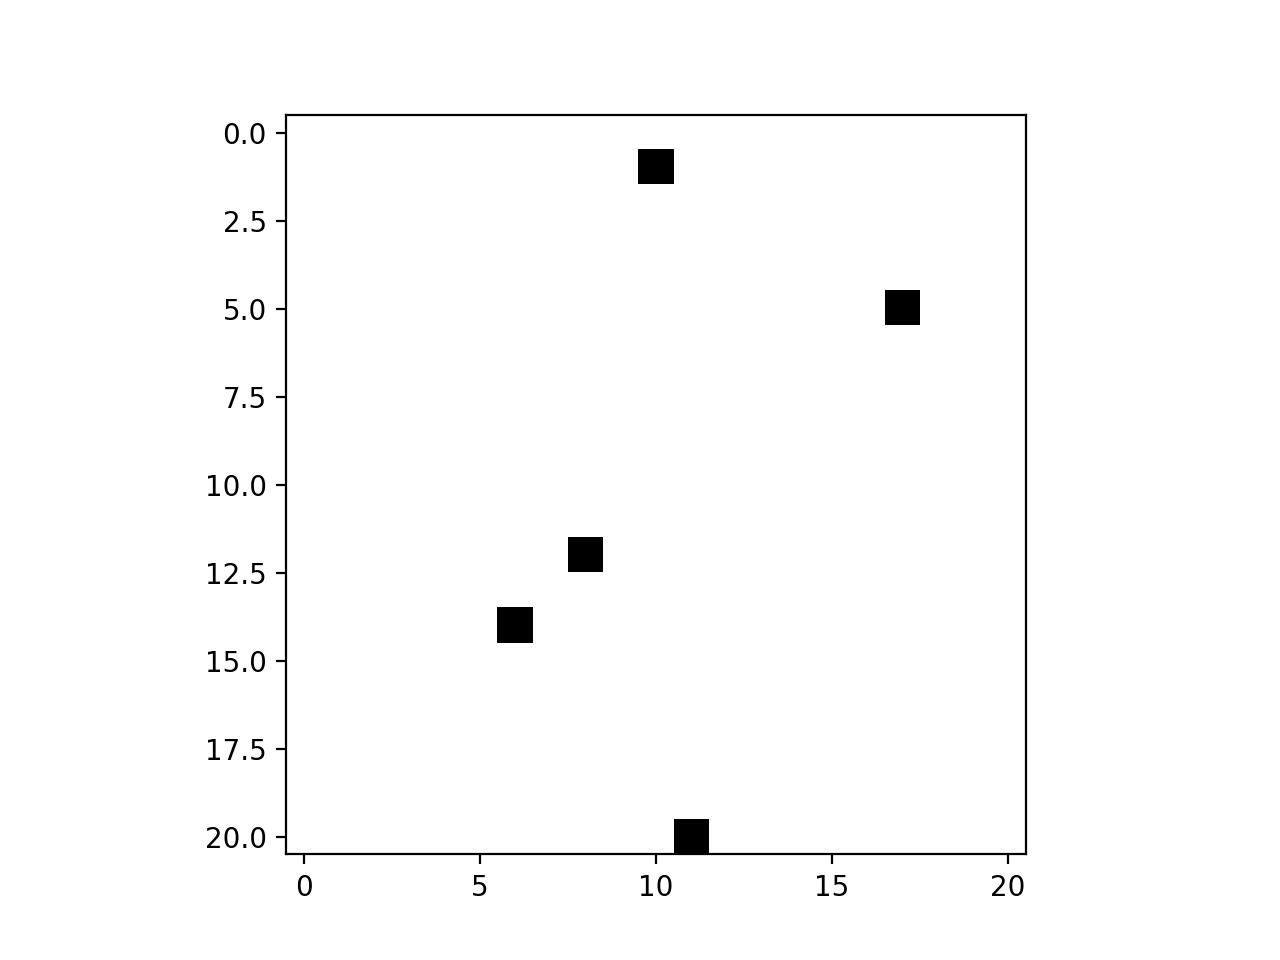

In [95]:
input_img_data = universe.get_state()

plt.figure()
plt.imshow(input_img_data[0, :,:,0], cmap="Greys")
plt.show()

conv2d_4


HBox(children=(IntProgress(value=0, max=64), HTML(value='')))

<IPython.core.display.Javascript object>


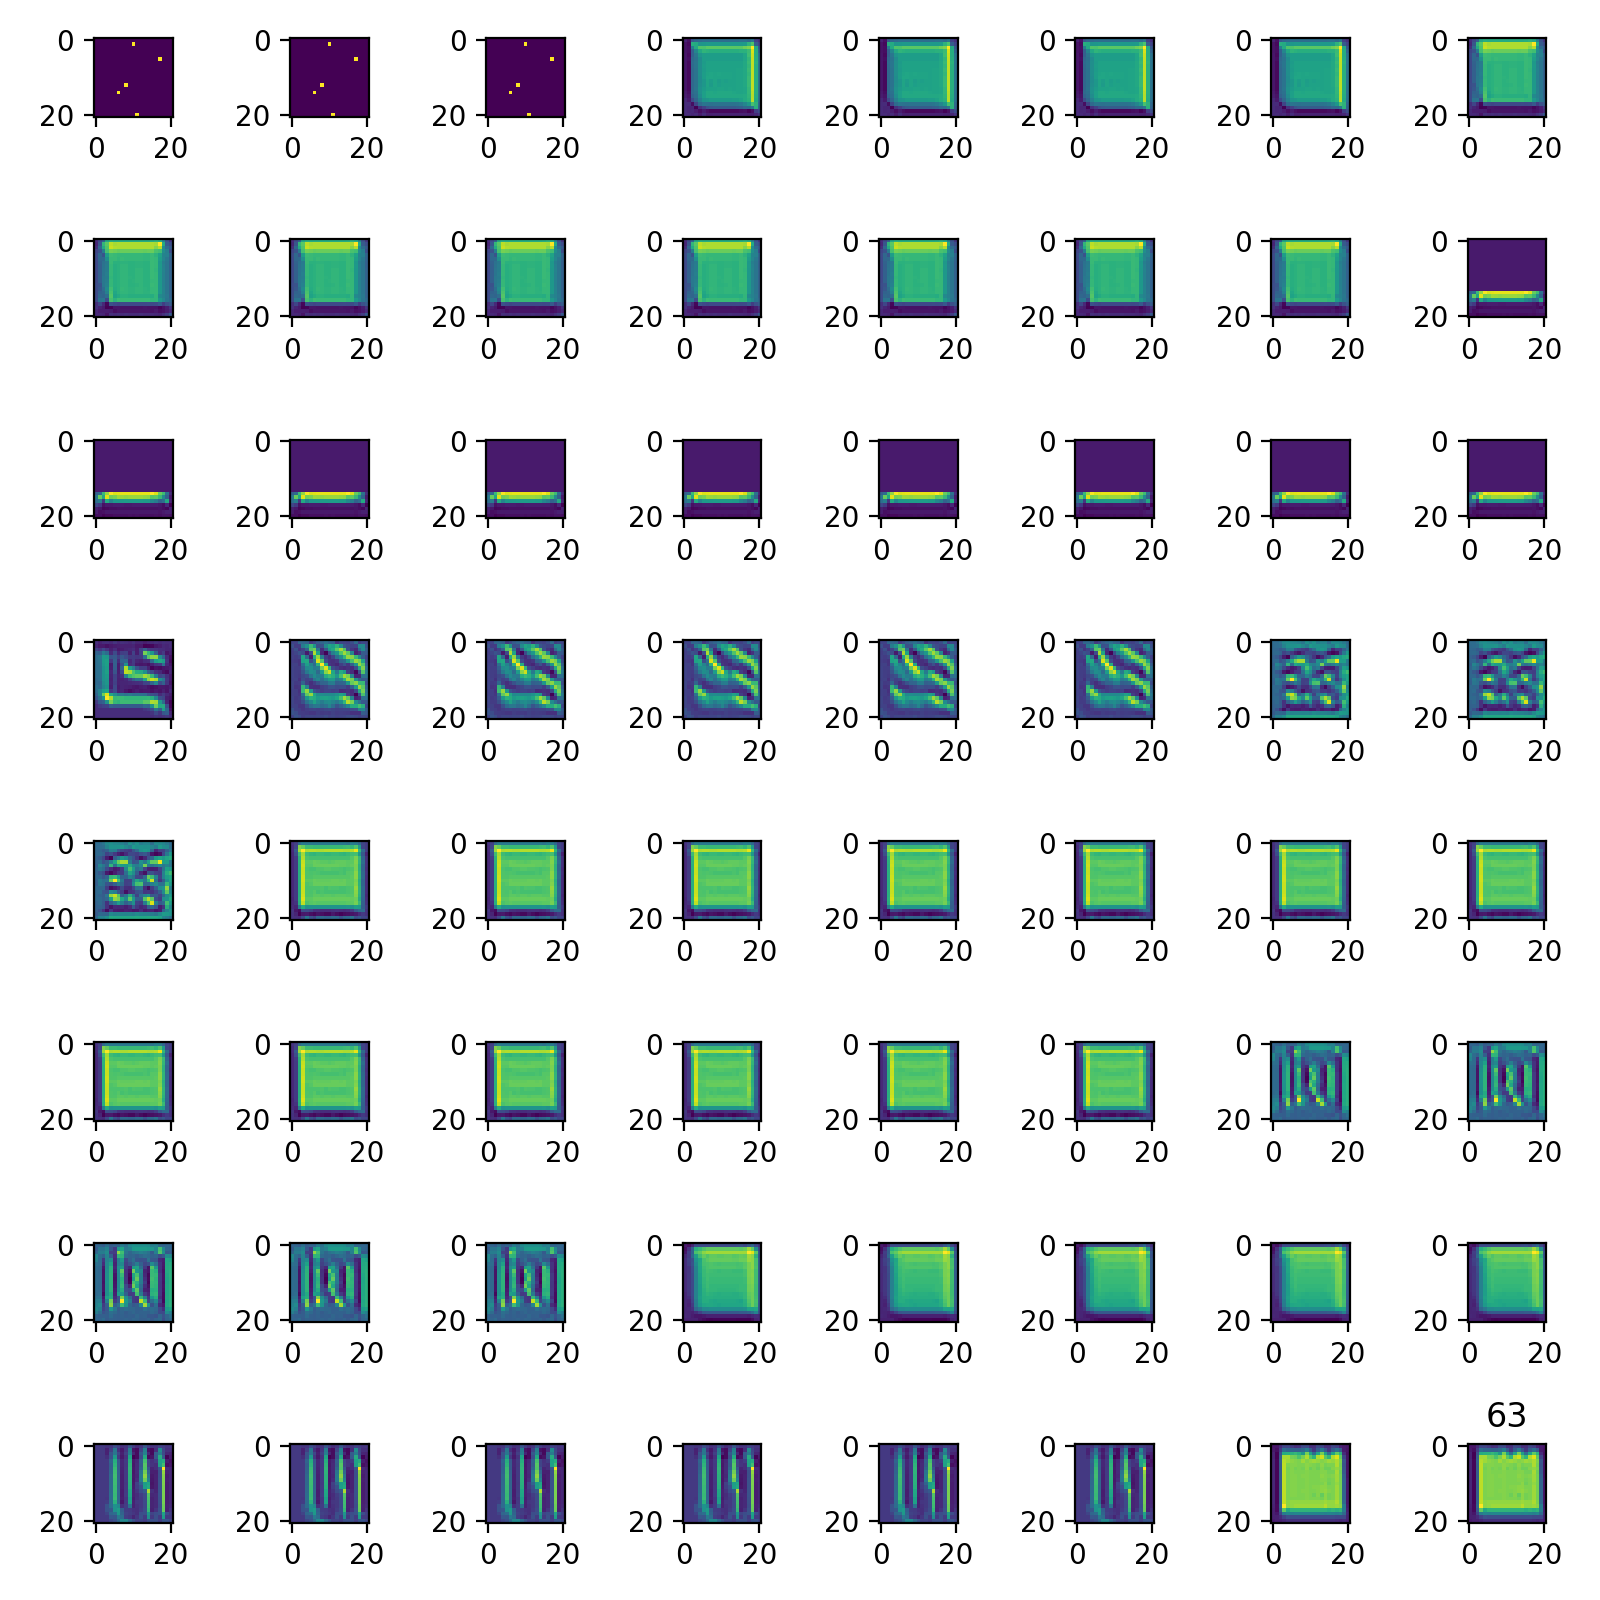

In [96]:
plot_activations(input_img_data)

## Up

<IPython.core.display.Javascript object>


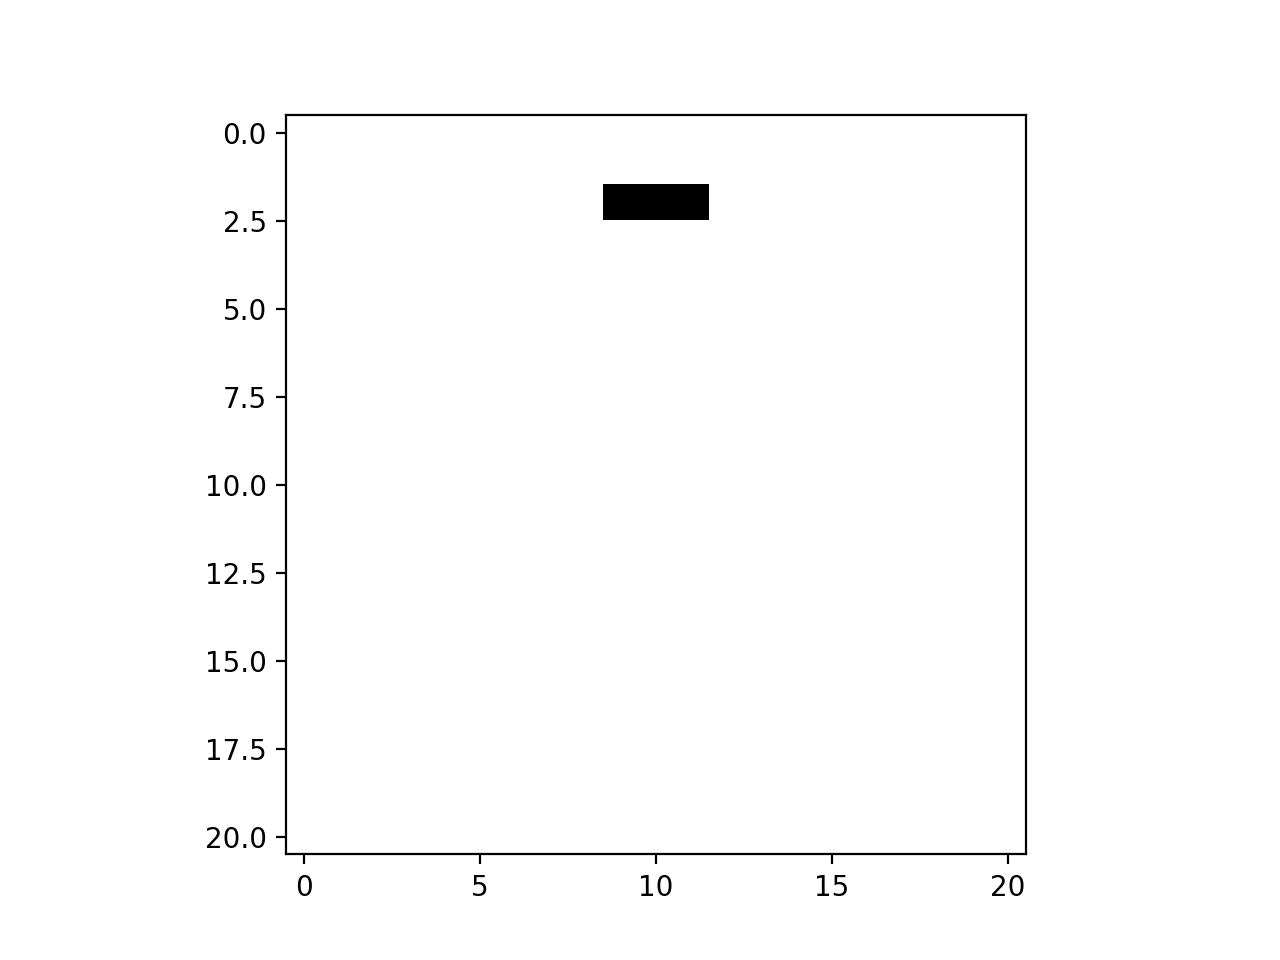

In [97]:
input_img_data = np.zeros(model.layers[0].input_shape[1:3])
input_img_data[2, 9:12] = 1
input_img_data = np.expand_dims(input_img_data, 2)
input_img_data = np.expand_dims(input_img_data, 0)

plt.figure()
plt.imshow(input_img_data[0, :,:,0], cmap="Greys")
plt.show()

conv2d_4


HBox(children=(IntProgress(value=0, max=64), HTML(value='')))

<IPython.core.display.Javascript object>


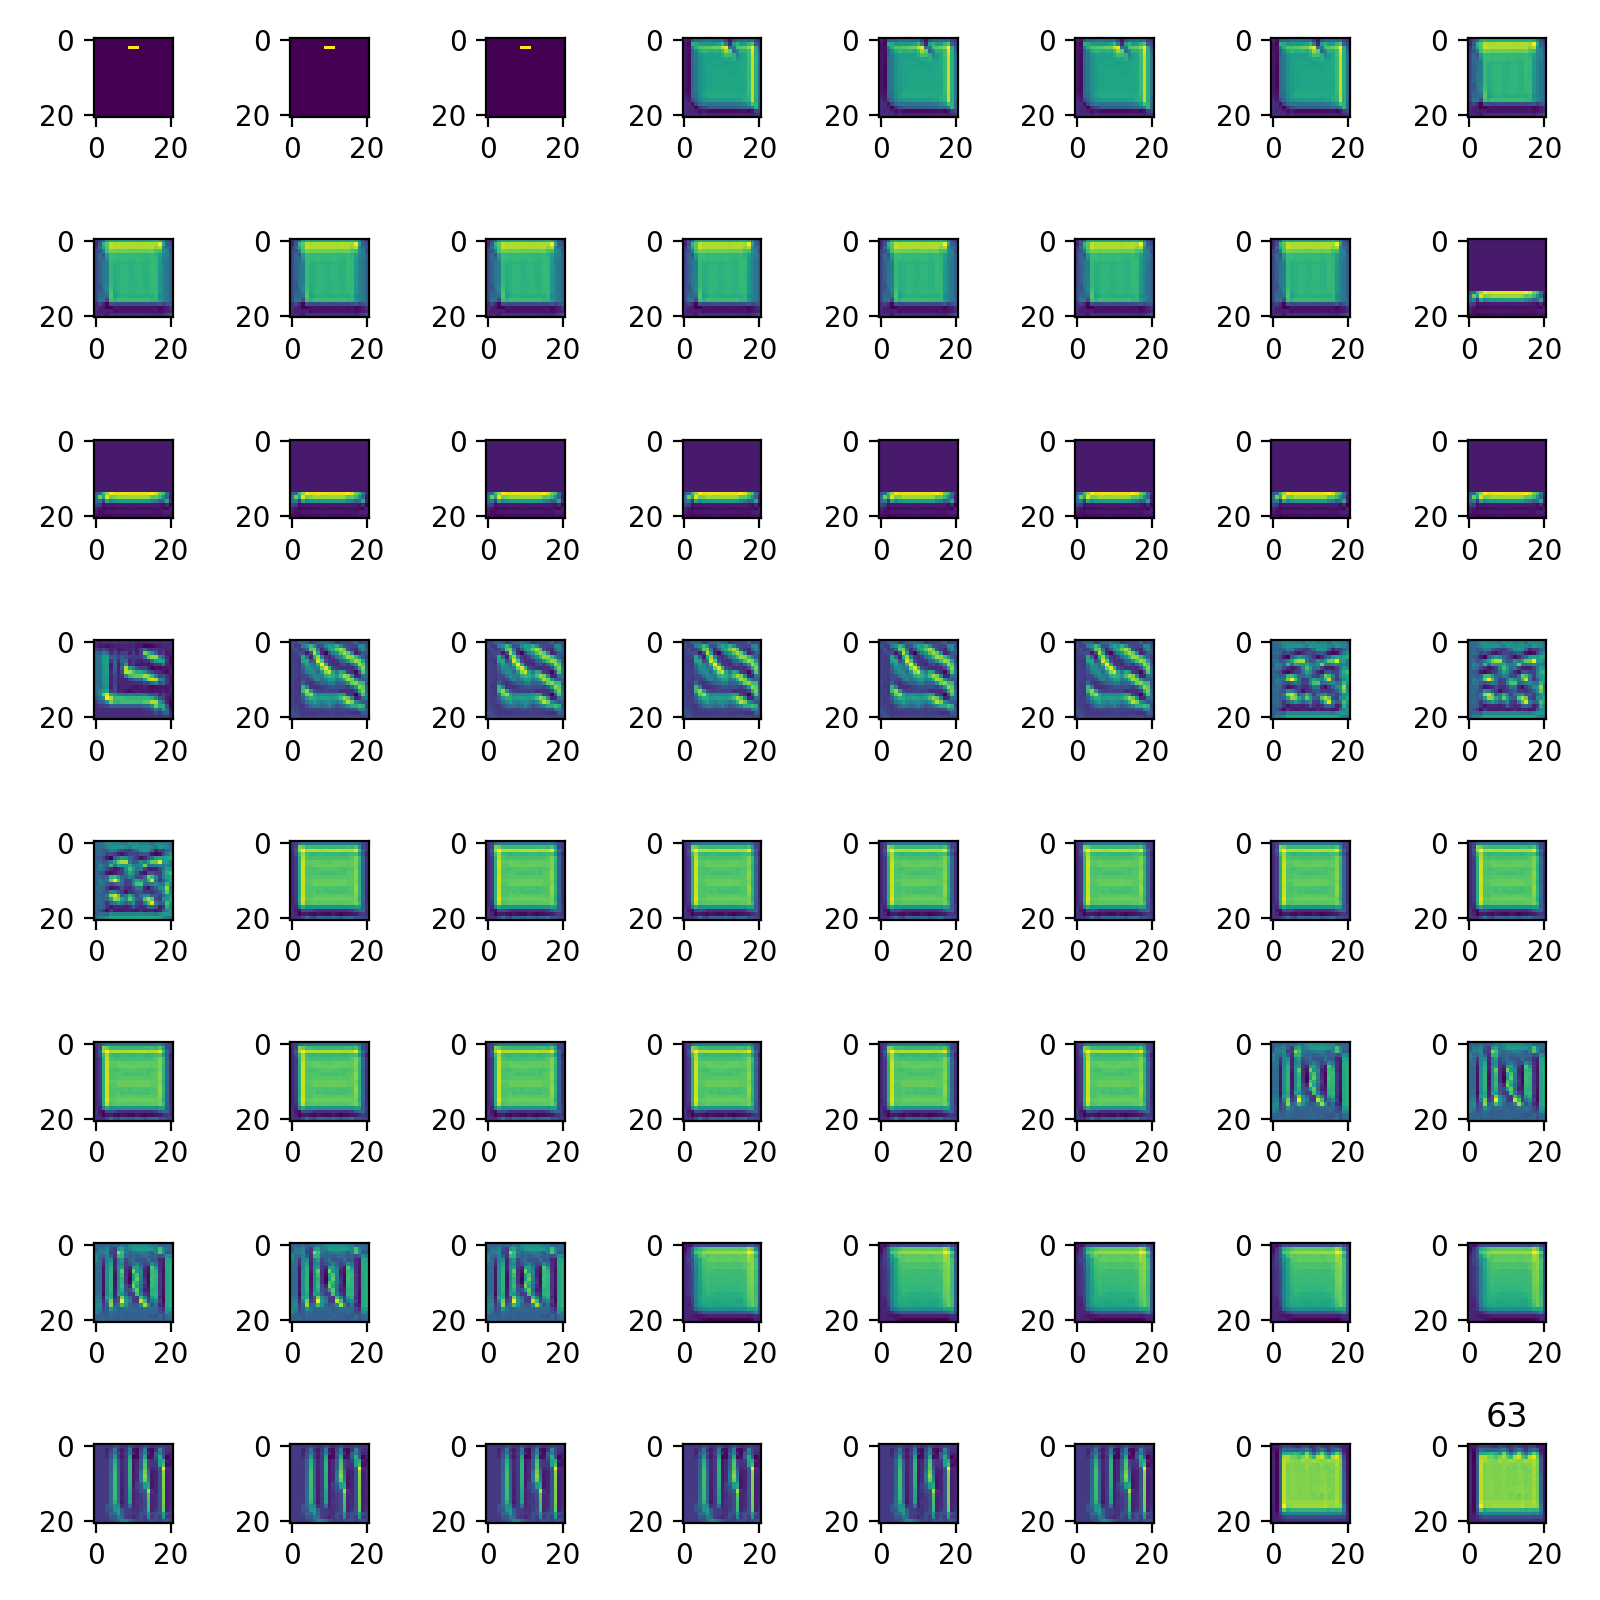

In [98]:
plot_activations(input_img_data)

## Right

<IPython.core.display.Javascript object>


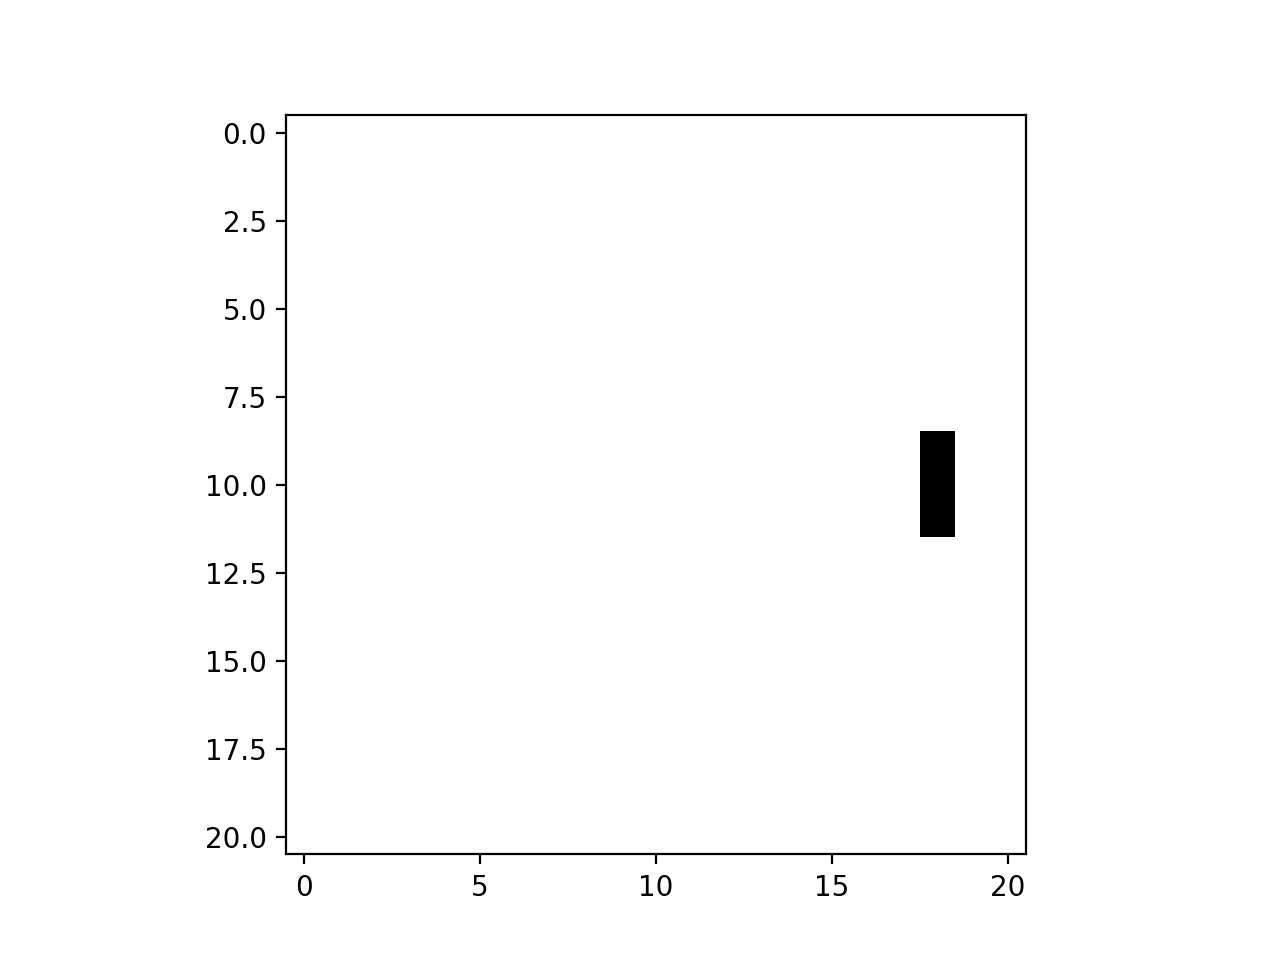

In [99]:
input_img_data = np.zeros(model.layers[0].input_shape[1:3])
input_img_data[9:12, 18] = 1
input_img_data = np.expand_dims(input_img_data, 2)
input_img_data = np.expand_dims(input_img_data, 0)

plt.figure()
plt.imshow(input_img_data[0, :,:,0], cmap="Greys")
plt.show()

conv2d_4


HBox(children=(IntProgress(value=0, max=64), HTML(value='')))

<IPython.core.display.Javascript object>


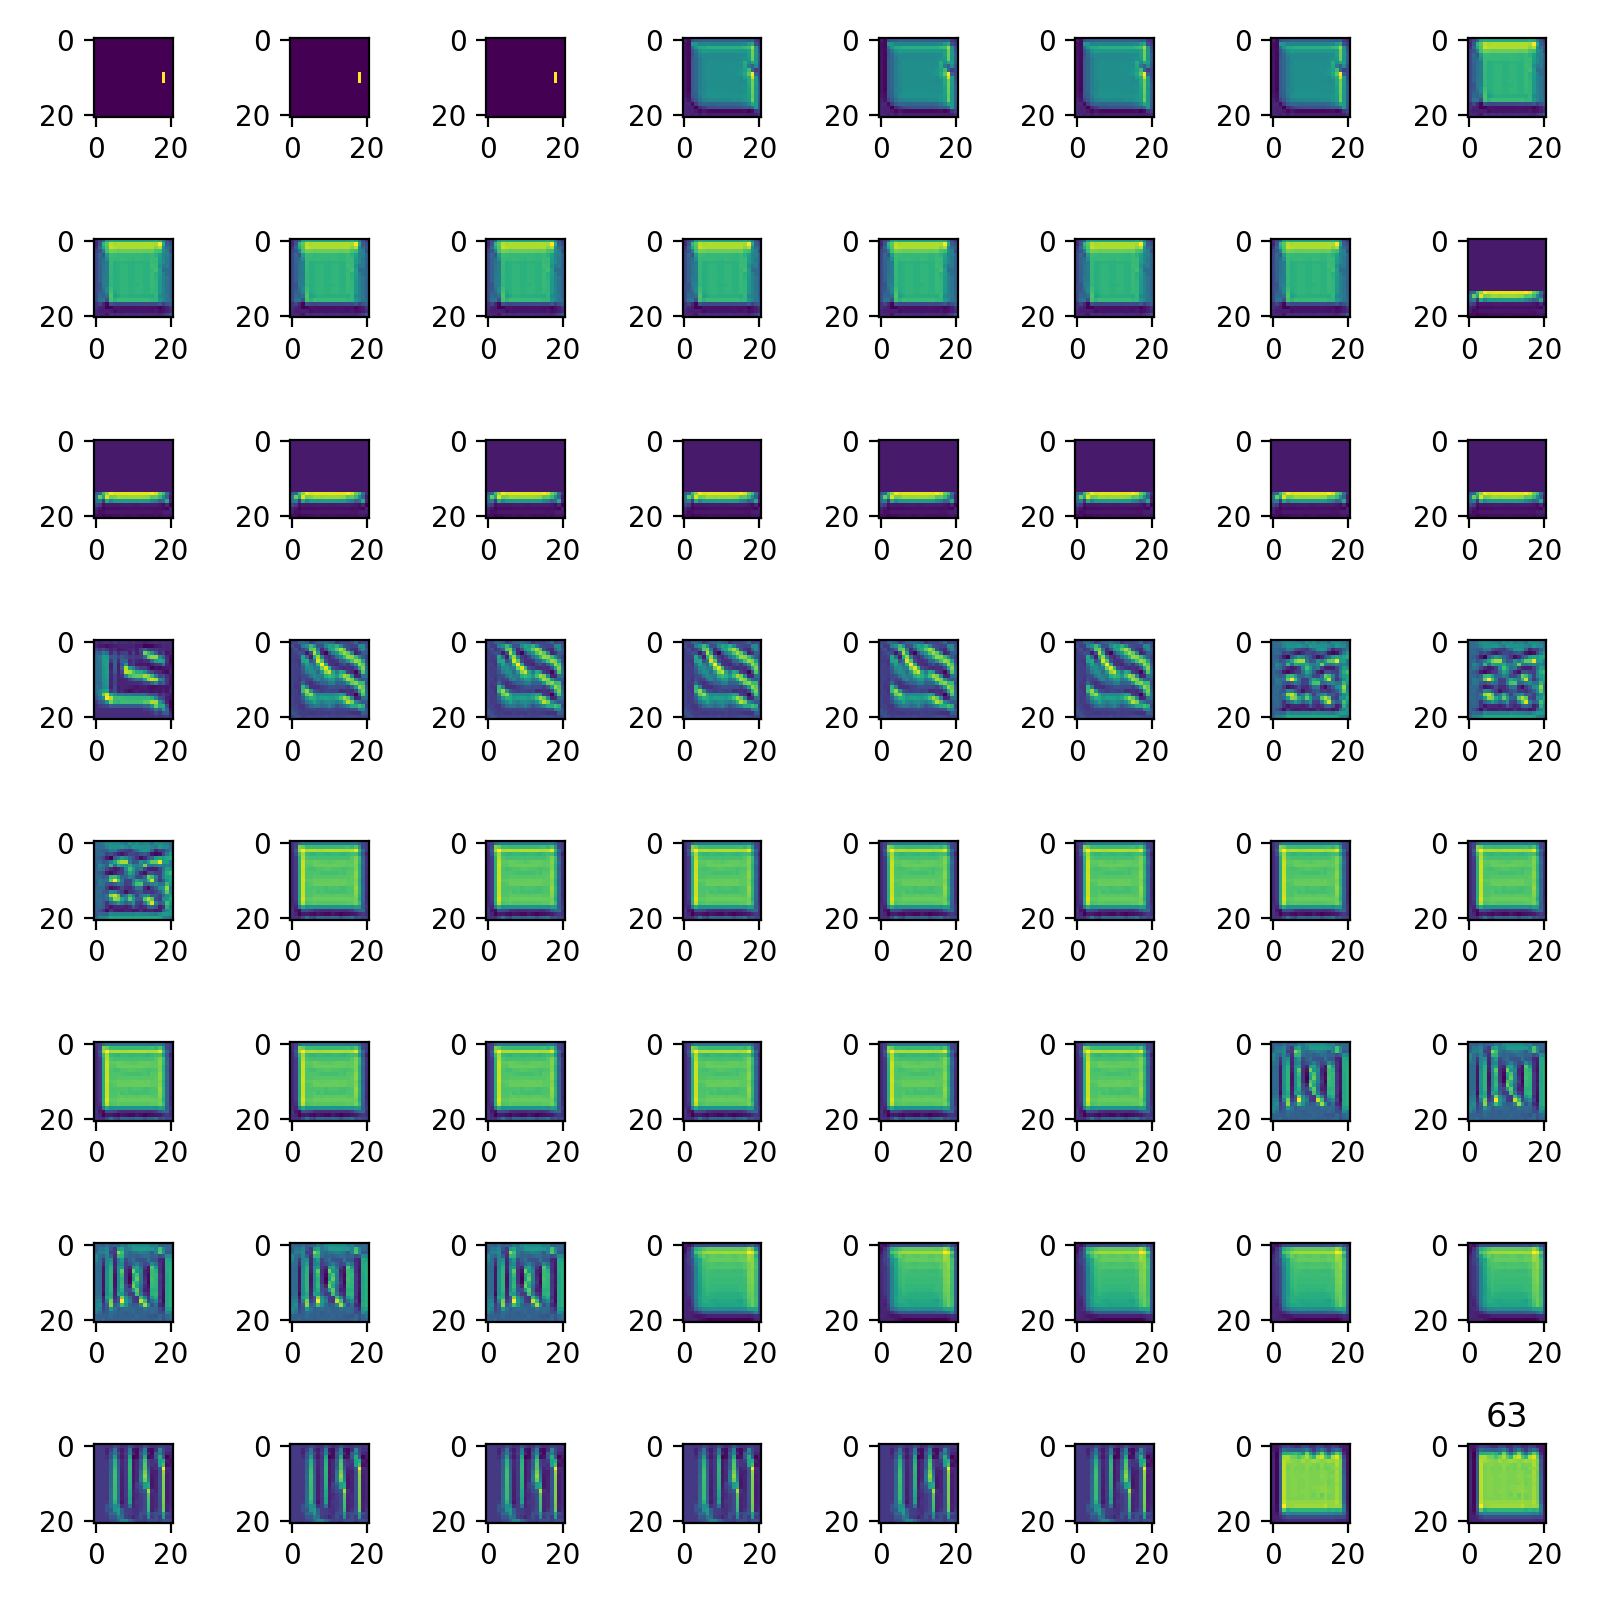

In [100]:
plot_activations(input_img_data)

## Down

<IPython.core.display.Javascript object>


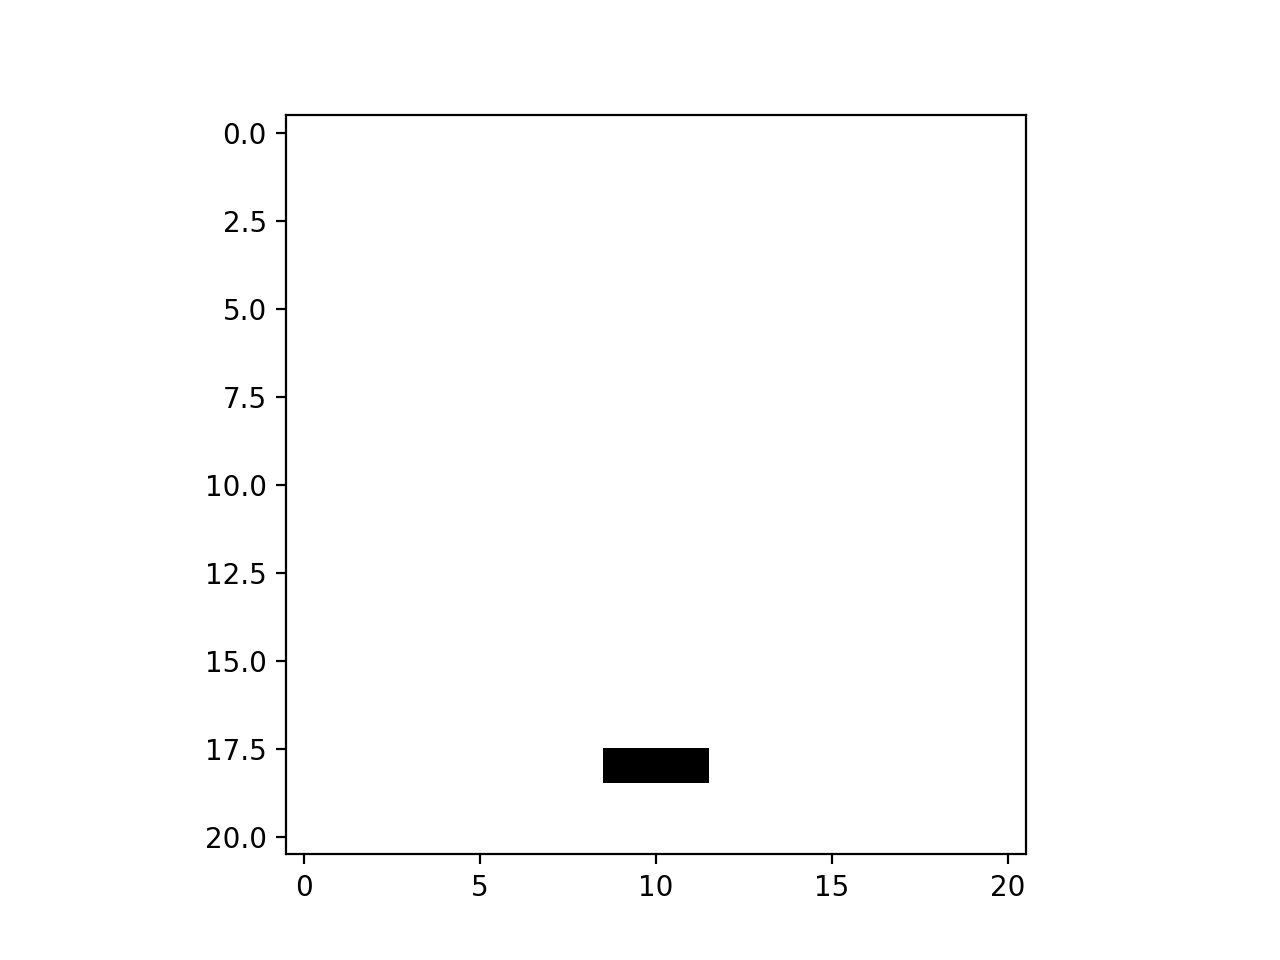

In [101]:
input_img_data = np.zeros(model.layers[0].input_shape[1:3])
input_img_data[18, 9:12] = 1
input_img_data = np.expand_dims(input_img_data, 2)
input_img_data = np.expand_dims(input_img_data, 0)

plt.figure()
plt.imshow(input_img_data[0, :,:,0], cmap="Greys")
plt.show()

conv2d_4


HBox(children=(IntProgress(value=0, max=64), HTML(value='')))

<IPython.core.display.Javascript object>


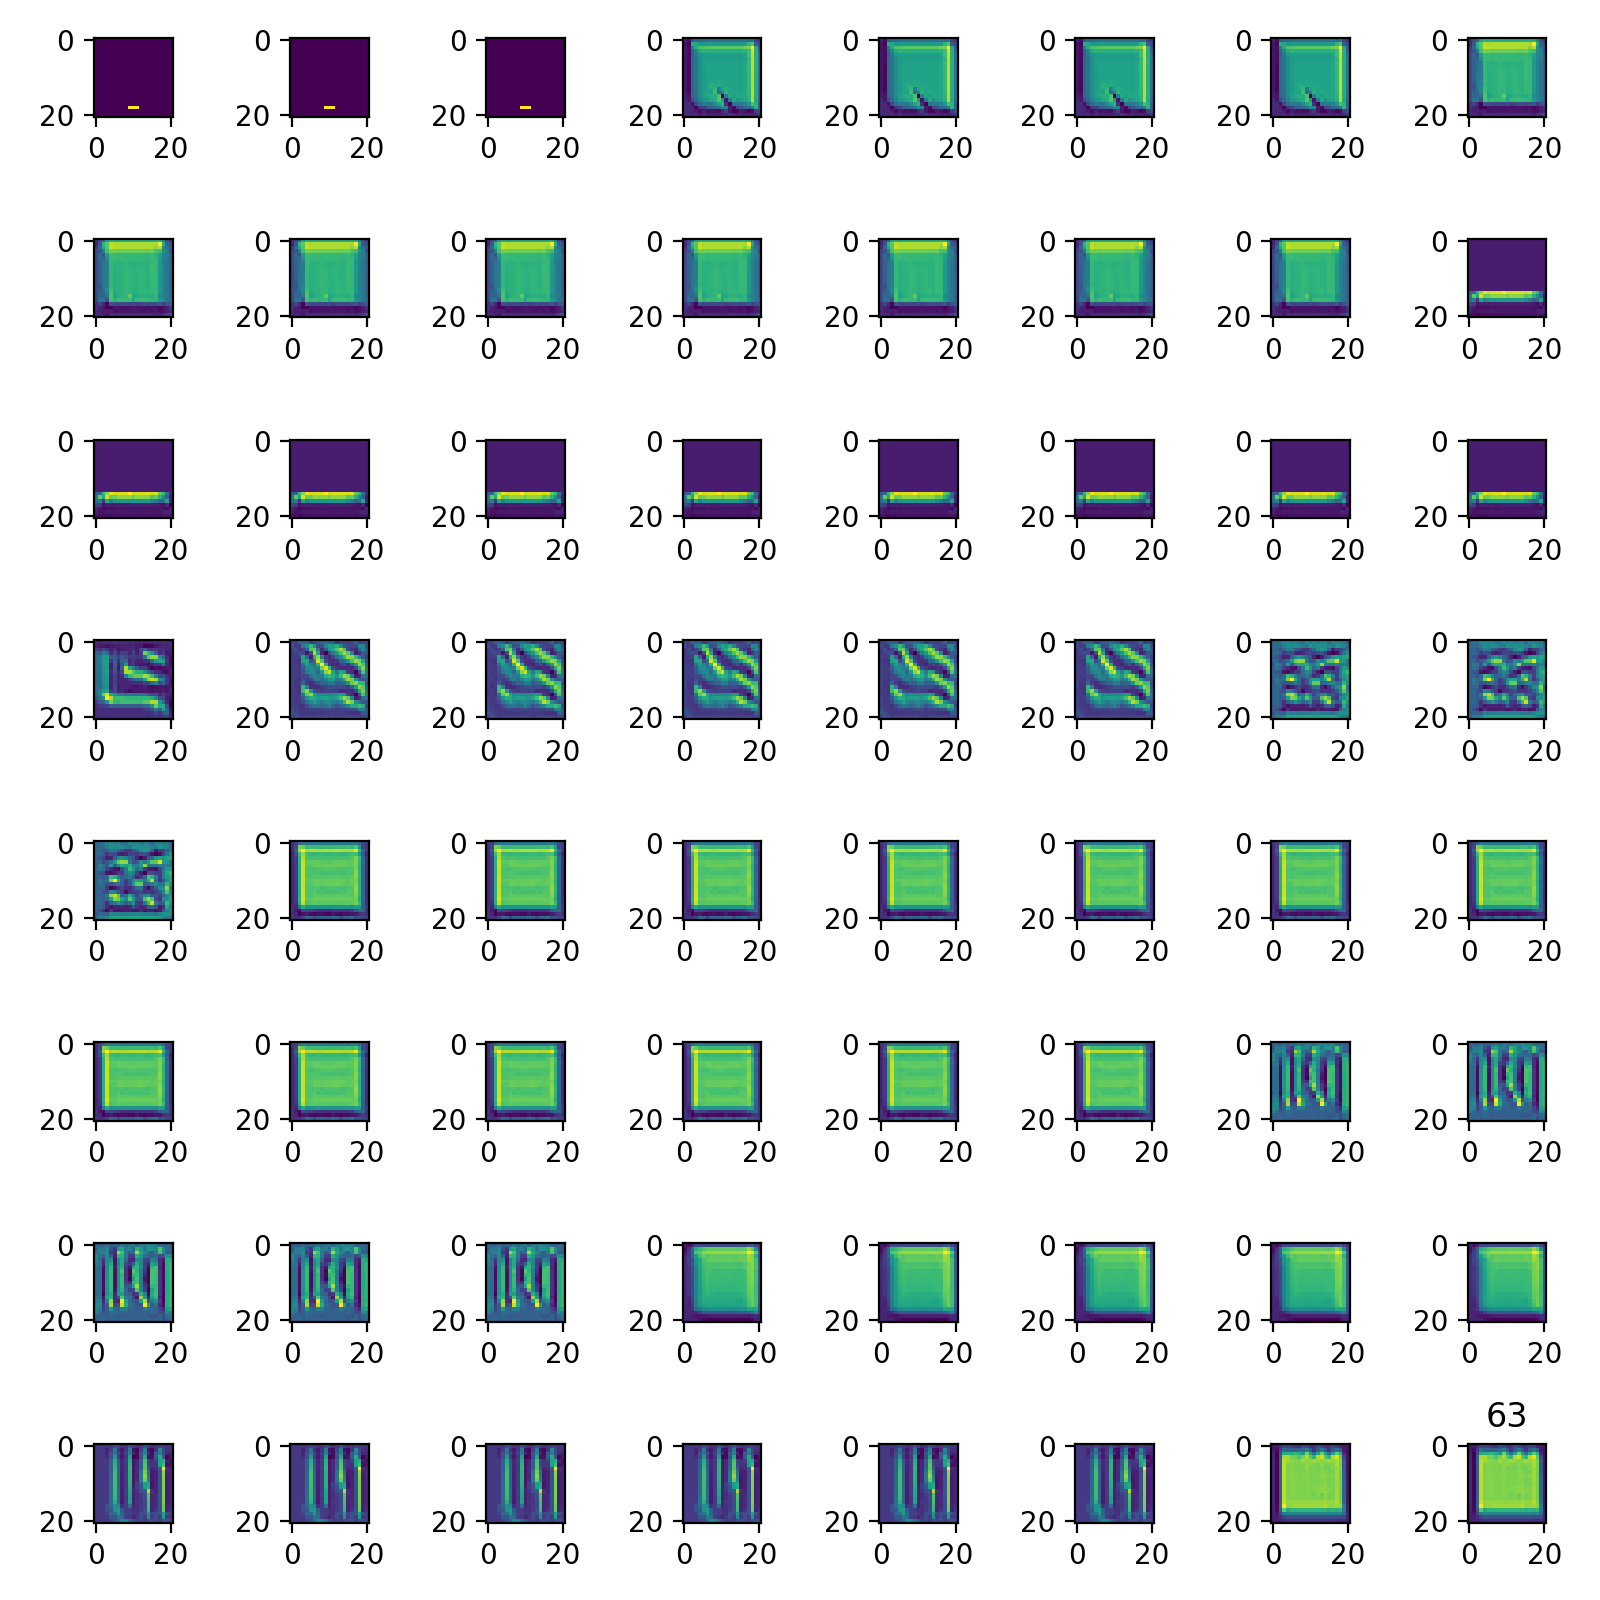

In [102]:
plot_activations(input_img_data)

## Left

<IPython.core.display.Javascript object>


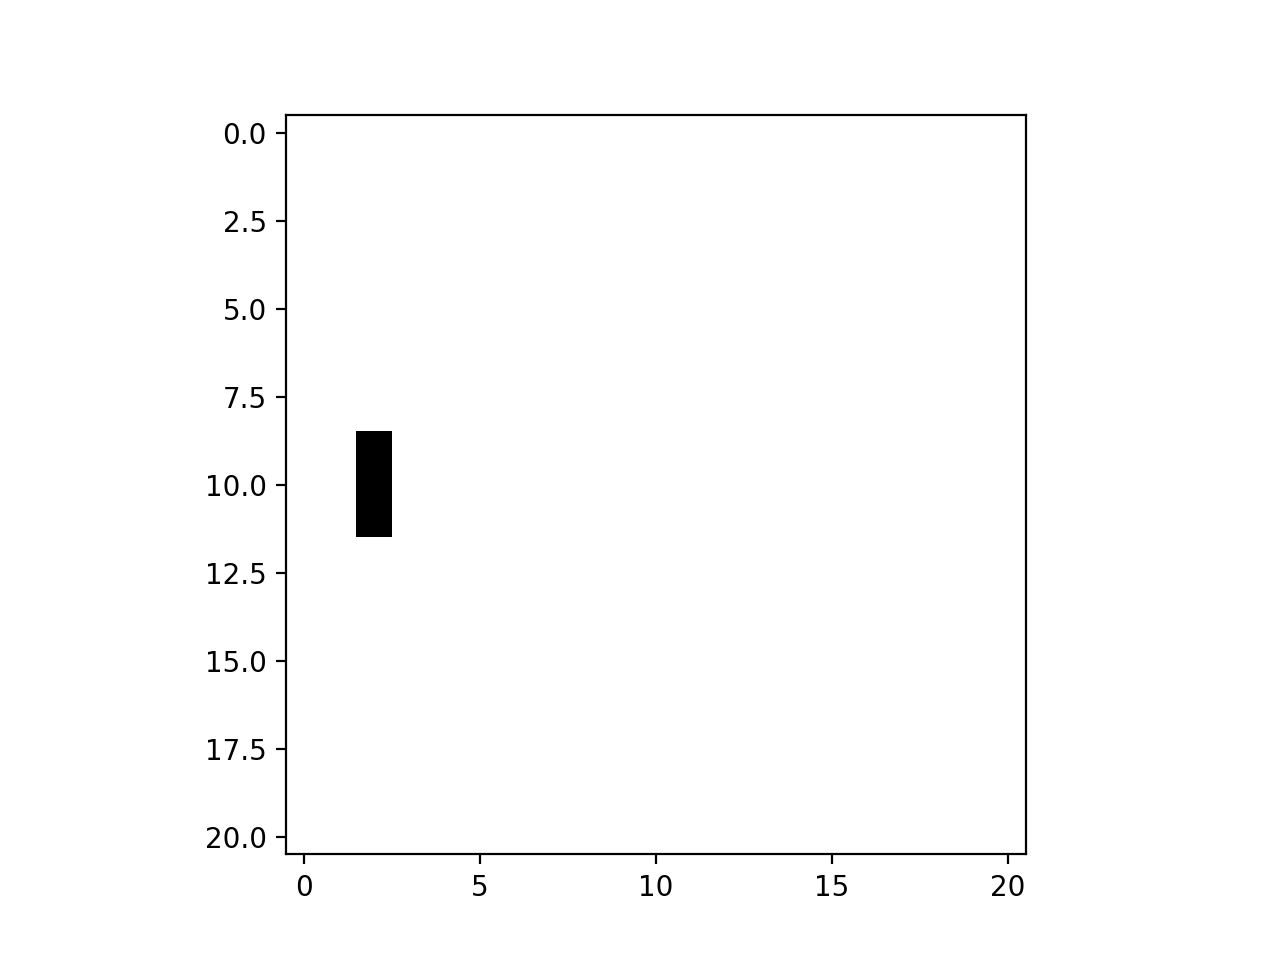

In [103]:
input_img_data = np.zeros(model.layers[0].input_shape[1:3])
input_img_data[9:12, 2] = 1
input_img_data = np.expand_dims(input_img_data, 2)
input_img_data = np.expand_dims(input_img_data, 0)

plt.figure()
plt.imshow(input_img_data[0, :,:,0], cmap="Greys")
plt.show()

conv2d_4


HBox(children=(IntProgress(value=0, max=64), HTML(value='')))

<IPython.core.display.Javascript object>


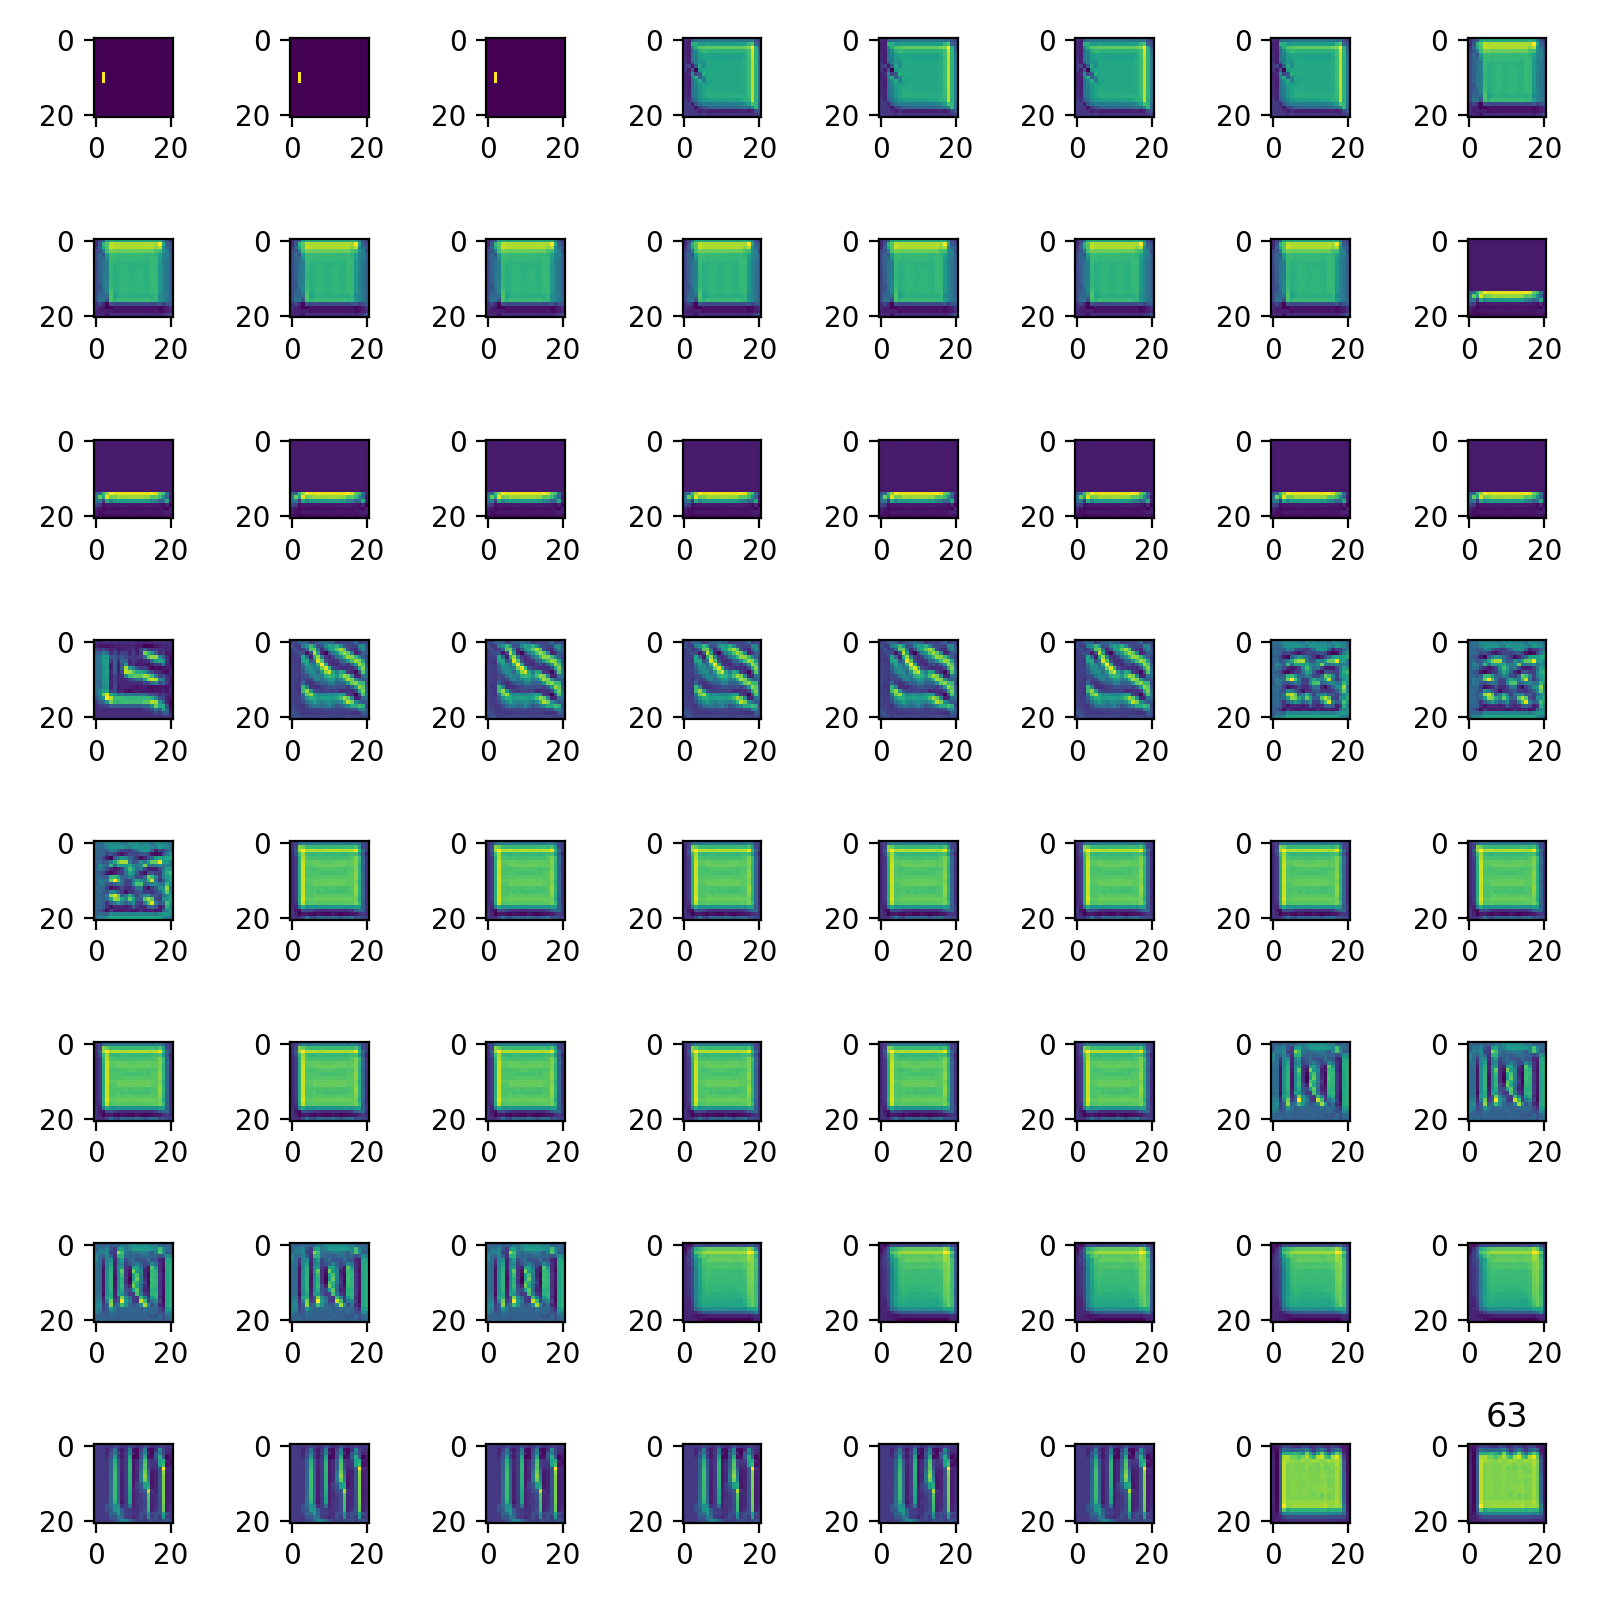

In [104]:
plot_activations(input_img_data)

---

---

In [105]:
model = models[10]

<IPython.core.display.Javascript object>


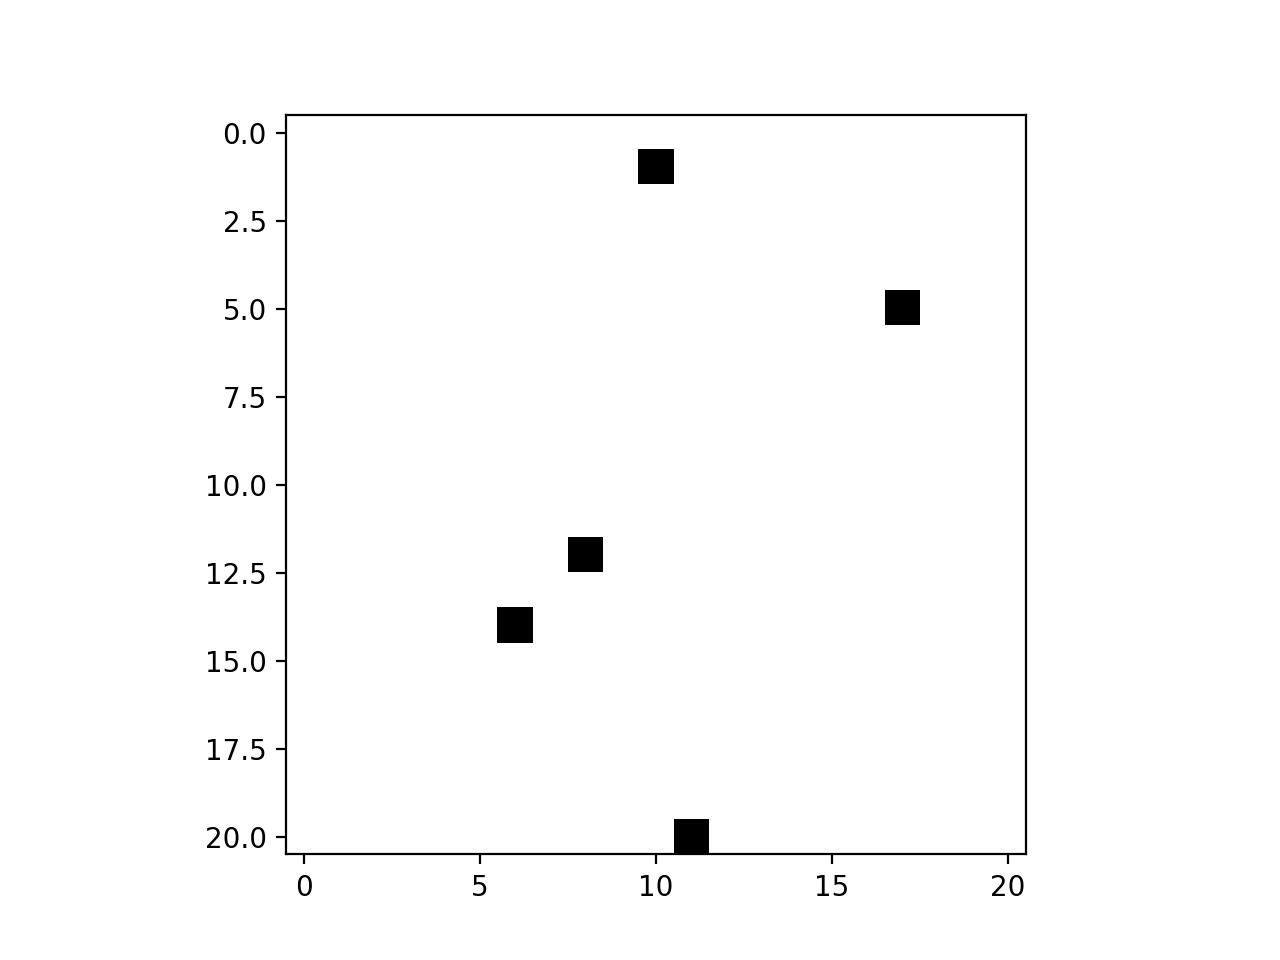

In [106]:
input_img_data = universe.get_state()

plt.figure()
plt.imshow(input_img_data[0, :,:,0], cmap="Greys")
plt.show()

conv2d_4


HBox(children=(IntProgress(value=0, max=64), HTML(value='')))

<IPython.core.display.Javascript object>


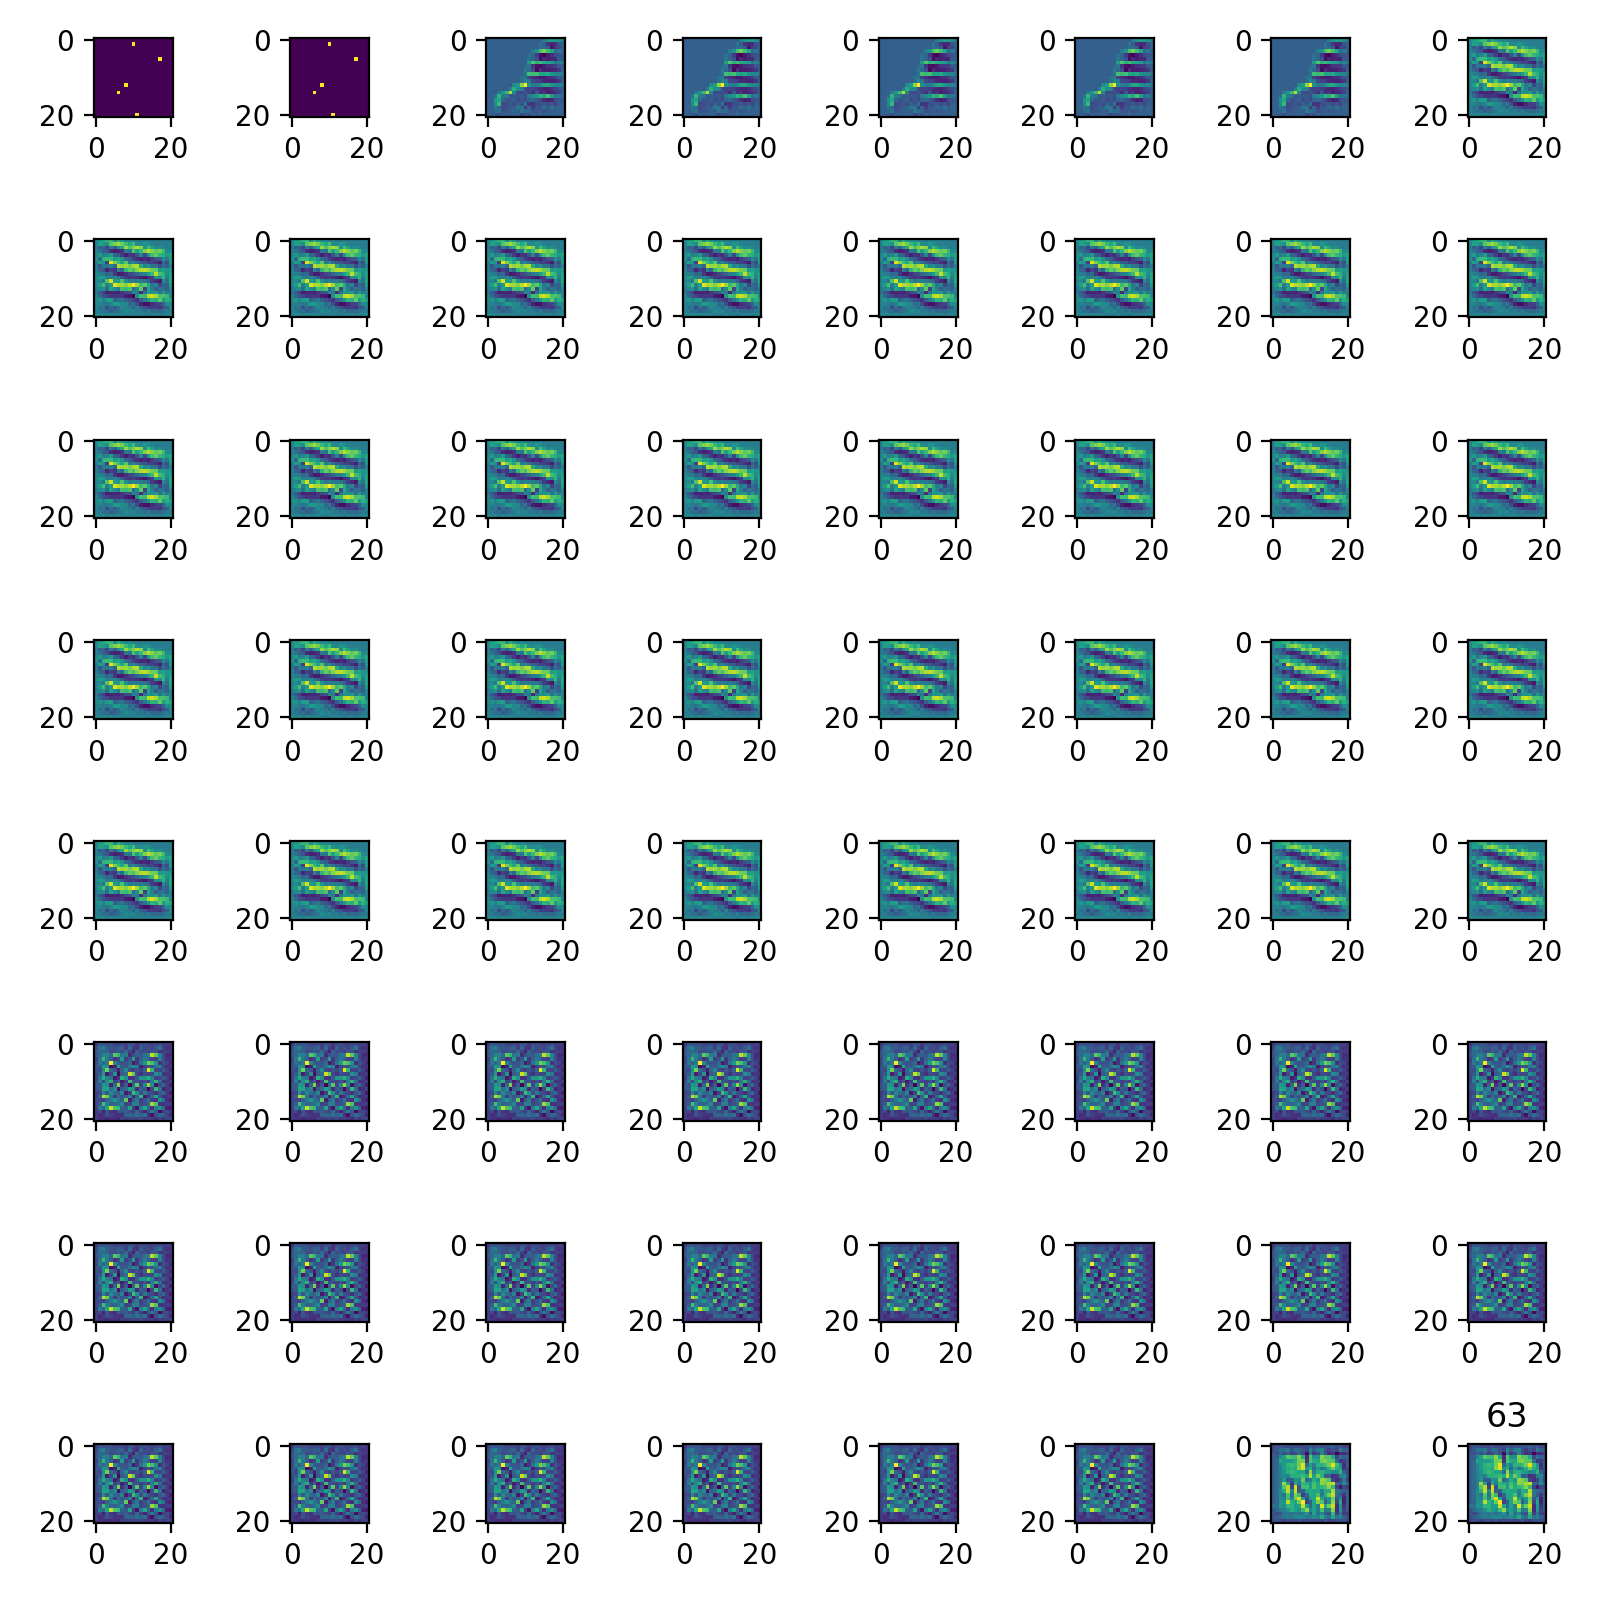

In [107]:
plot_activations(input_img_data)

## Up

<IPython.core.display.Javascript object>


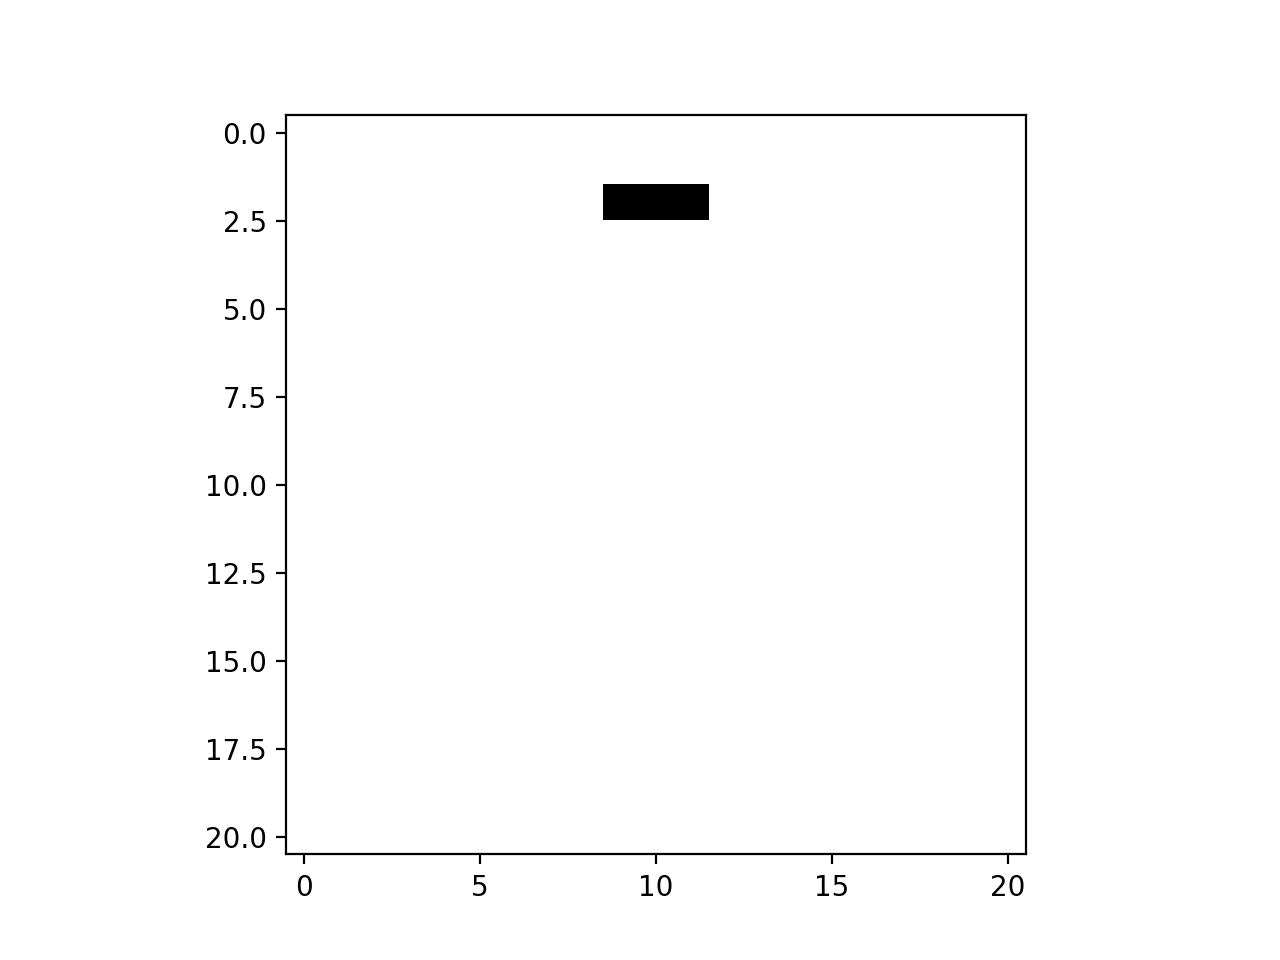

In [108]:
input_img_data = np.zeros(model.layers[0].input_shape[1:3])
input_img_data[2, 9:12] = 1
input_img_data = np.expand_dims(input_img_data, 2)
input_img_data = np.expand_dims(input_img_data, 0)

plt.figure()
plt.imshow(input_img_data[0, :,:,0], cmap="Greys")
plt.show()

conv2d_4


HBox(children=(IntProgress(value=0, max=64), HTML(value='')))

<IPython.core.display.Javascript object>


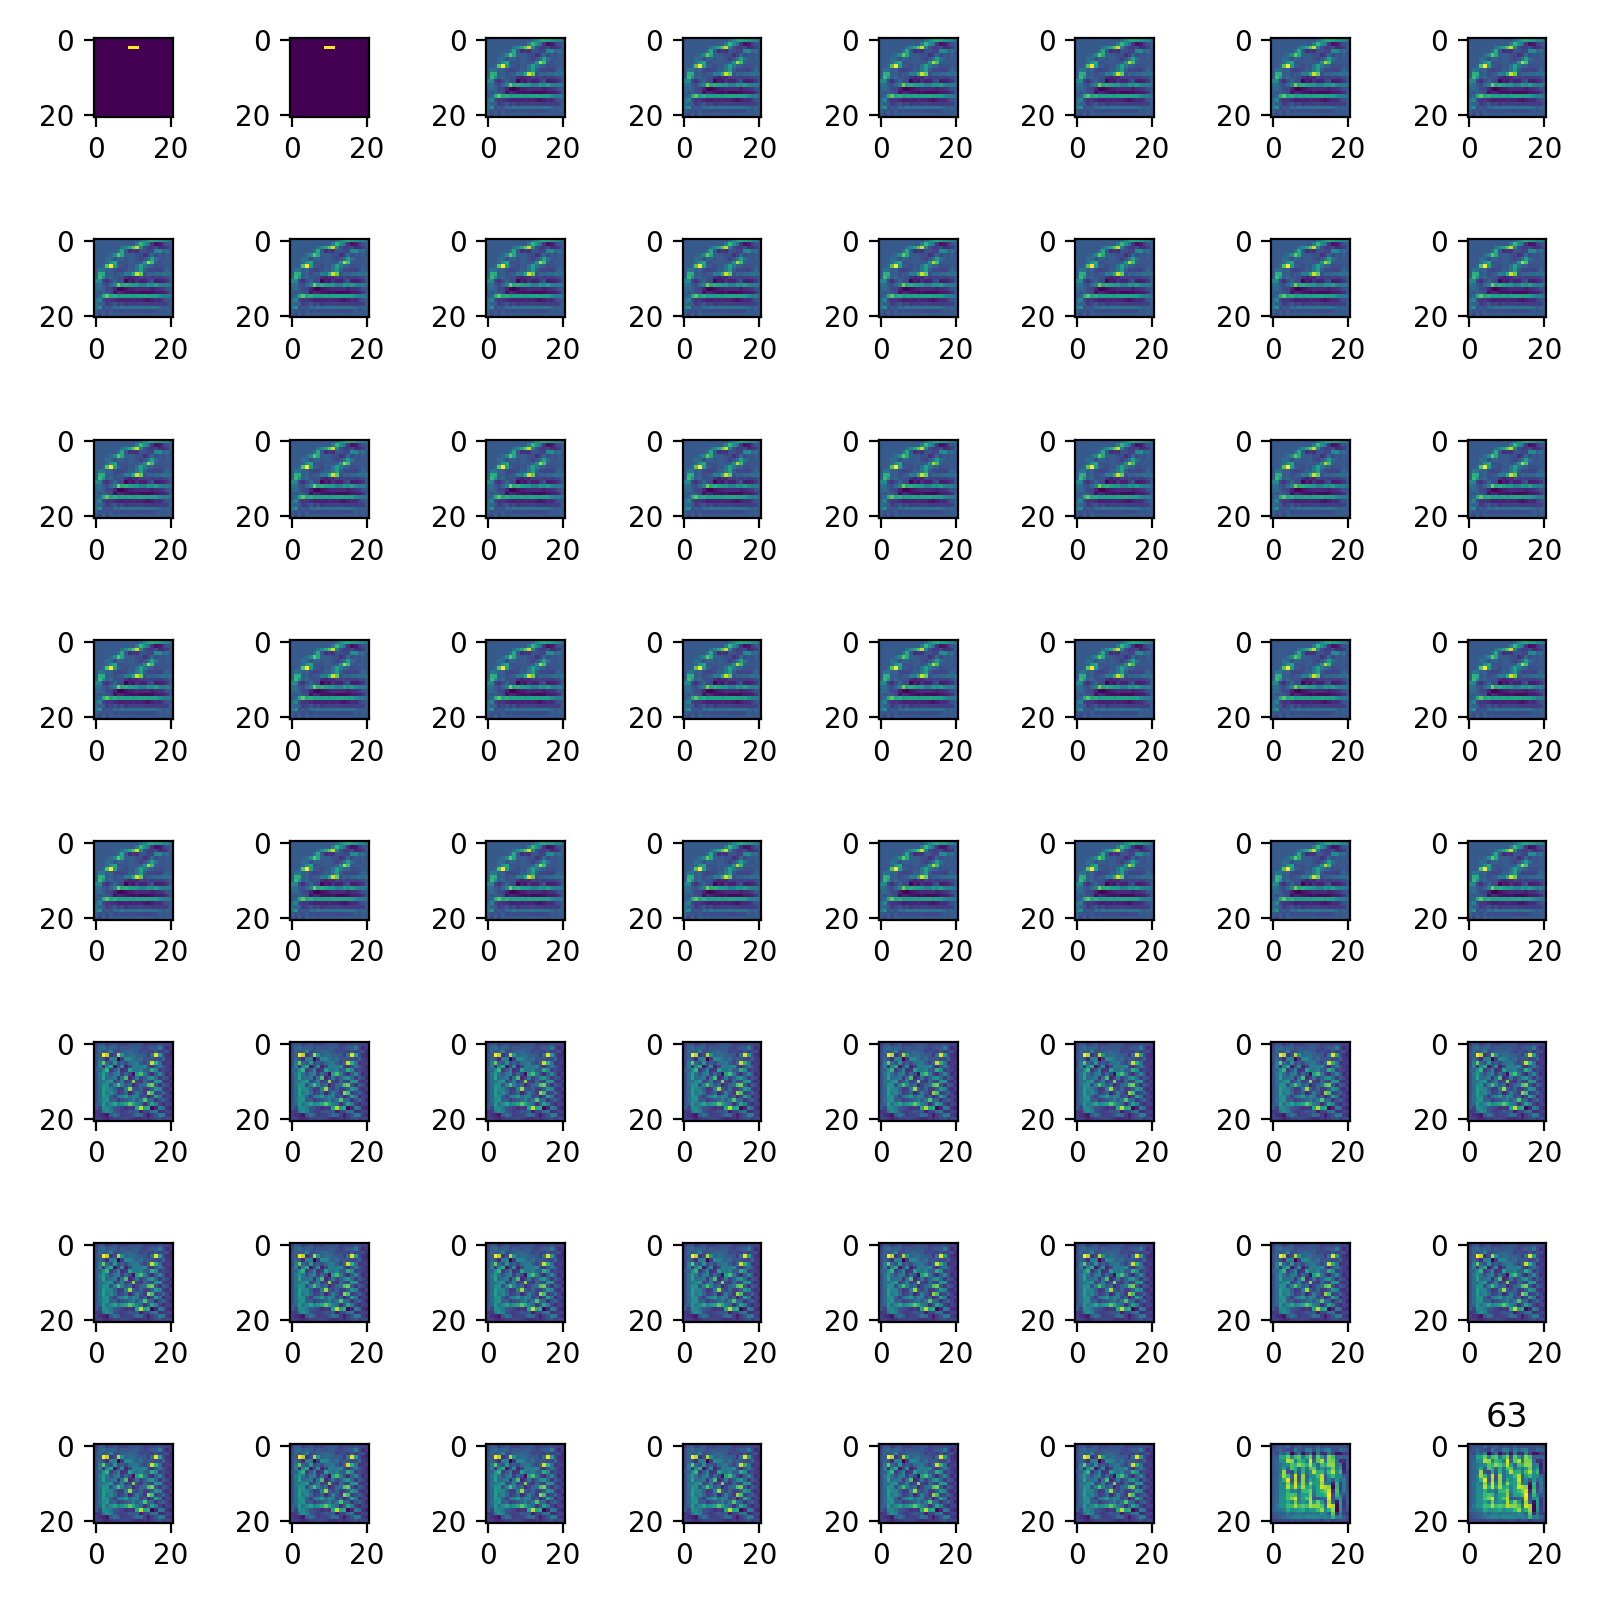

In [109]:
plot_activations(input_img_data)

## Right

<IPython.core.display.Javascript object>


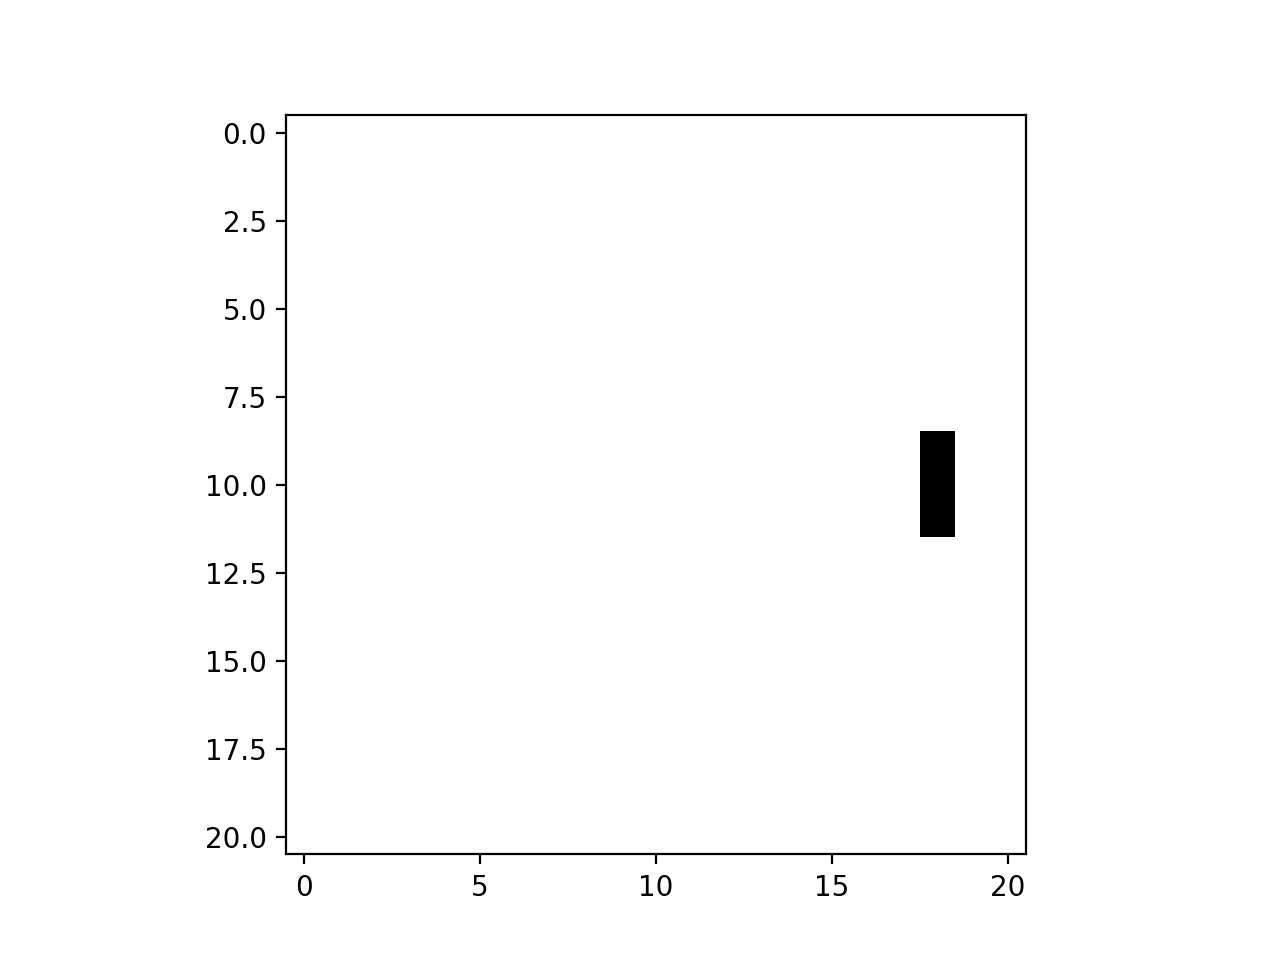

In [110]:
input_img_data = np.zeros(model.layers[0].input_shape[1:3])
input_img_data[9:12, 18] = 1
input_img_data = np.expand_dims(input_img_data, 2)
input_img_data = np.expand_dims(input_img_data, 0)

plt.figure()
plt.imshow(input_img_data[0, :,:,0], cmap="Greys")
plt.show()

conv2d_4


HBox(children=(IntProgress(value=0, max=64), HTML(value='')))

<IPython.core.display.Javascript object>


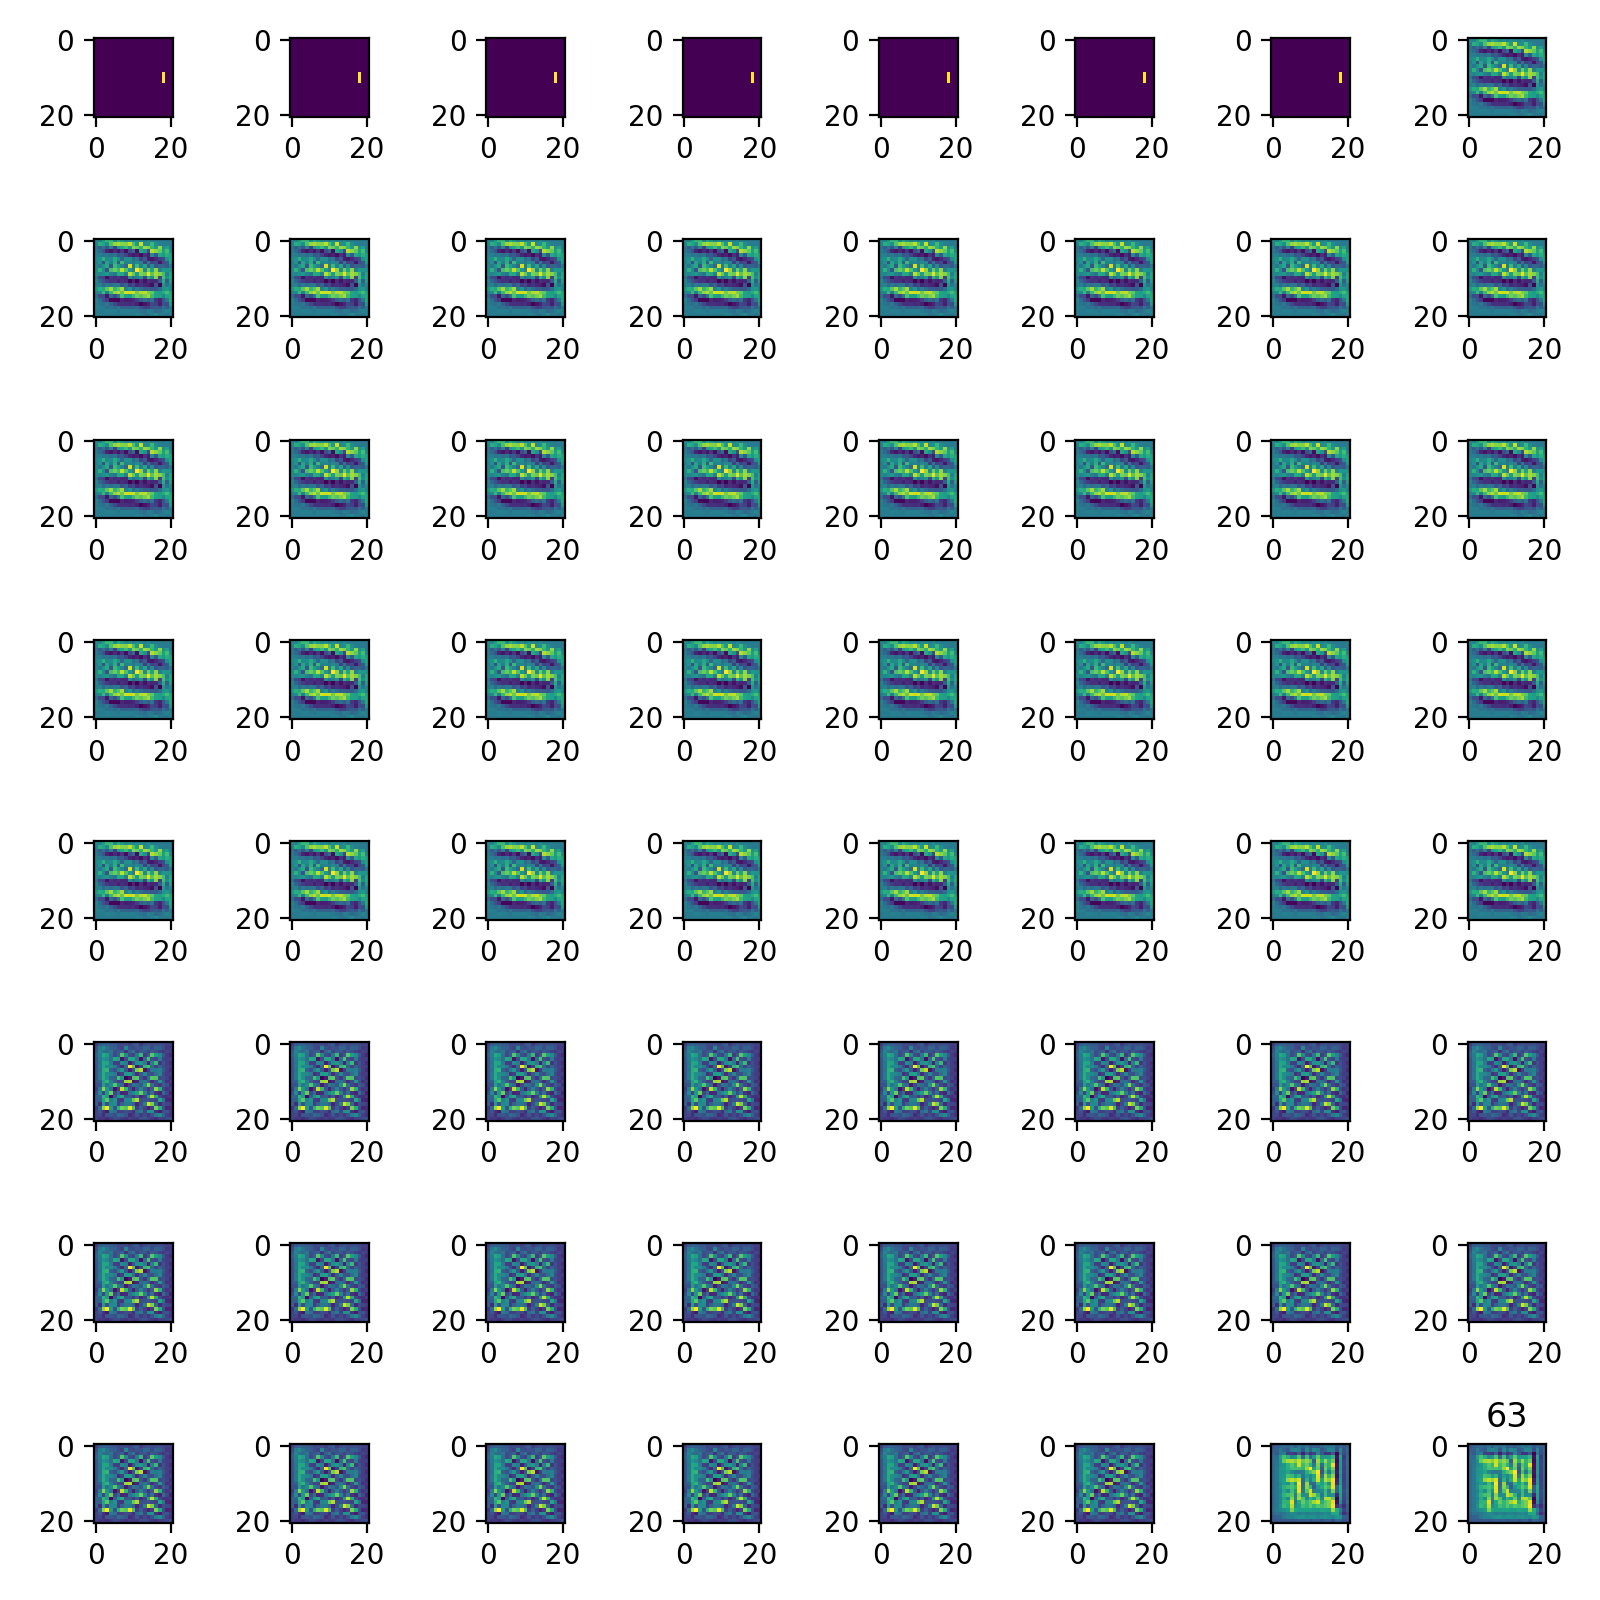

In [111]:
plot_activations(input_img_data)

## Down

<IPython.core.display.Javascript object>


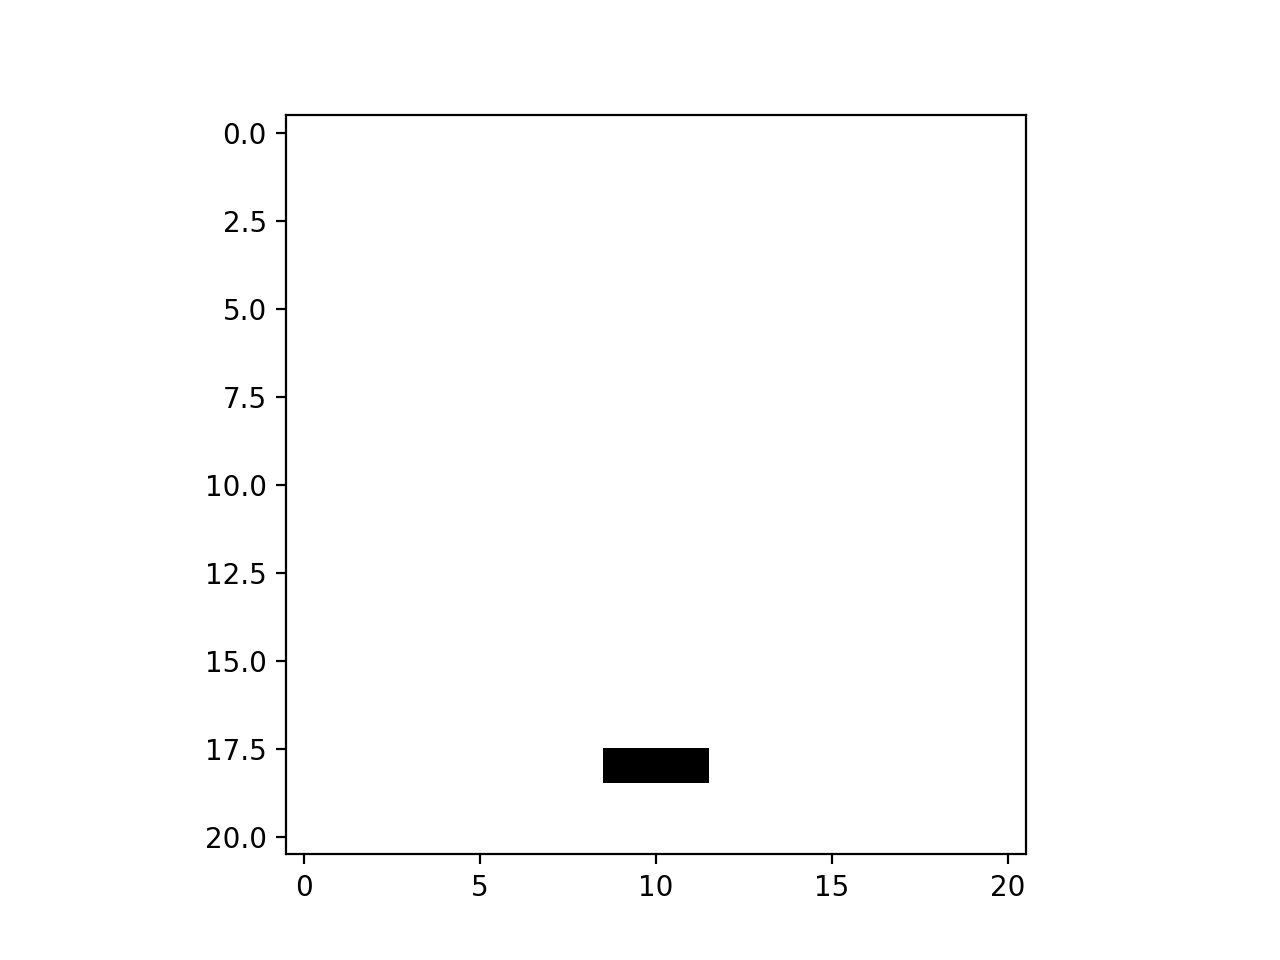

In [112]:
input_img_data = np.zeros(model.layers[0].input_shape[1:3])
input_img_data[18, 9:12] = 1
input_img_data = np.expand_dims(input_img_data, 2)
input_img_data = np.expand_dims(input_img_data, 0)

plt.figure()
plt.imshow(input_img_data[0, :,:,0], cmap="Greys")
plt.show()

conv2d_4


HBox(children=(IntProgress(value=0, max=64), HTML(value='')))

<IPython.core.display.Javascript object>


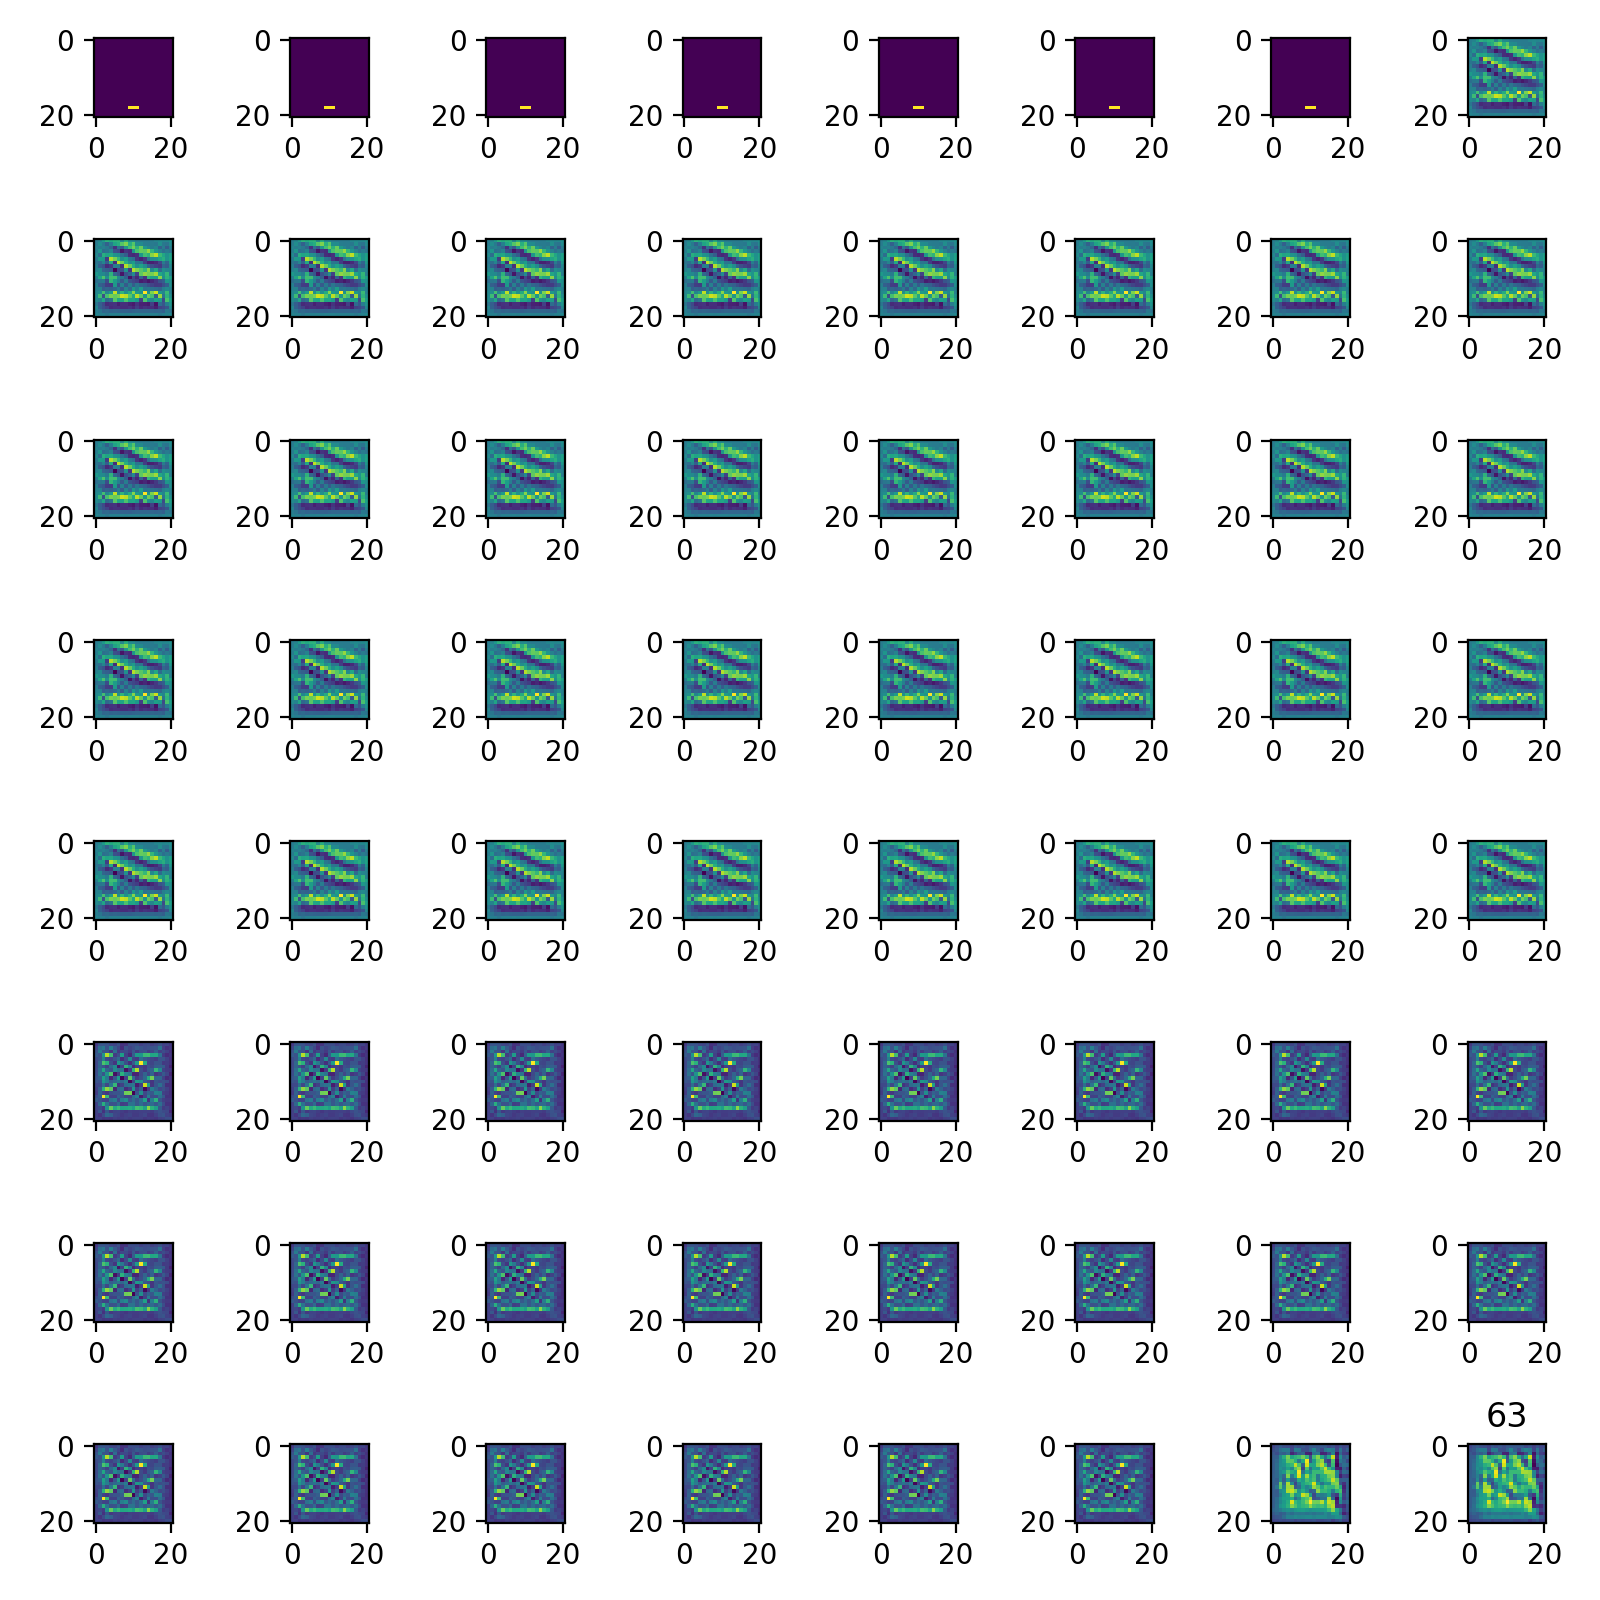

In [113]:
plot_activations(input_img_data)

## Left

<IPython.core.display.Javascript object>


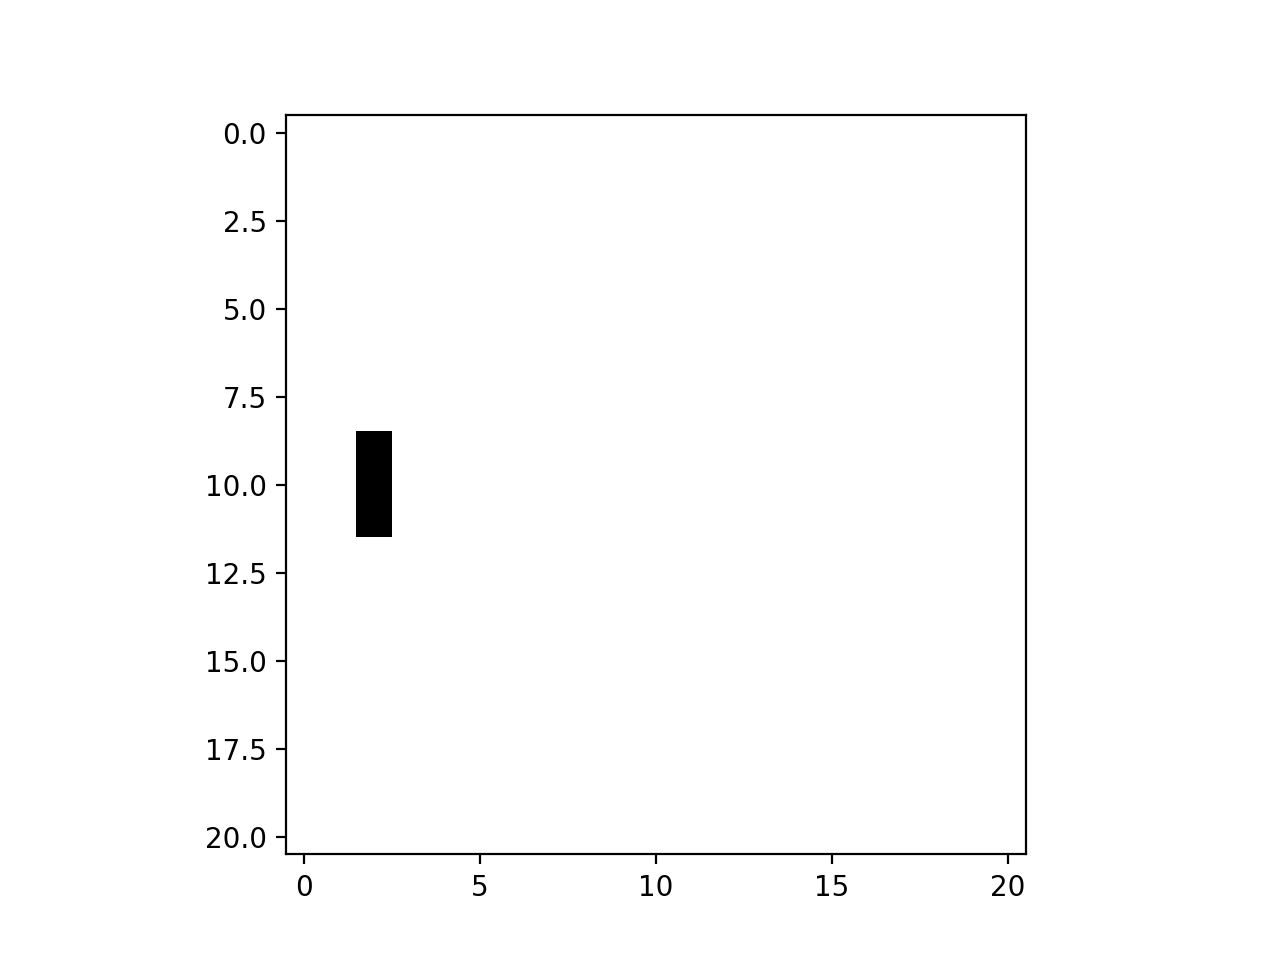

In [114]:
input_img_data = np.zeros(model.layers[0].input_shape[1:3])
input_img_data[9:12, 2] = 1
input_img_data = np.expand_dims(input_img_data, 2)
input_img_data = np.expand_dims(input_img_data, 0)

plt.figure()
plt.imshow(input_img_data[0, :,:,0], cmap="Greys")
plt.show()

conv2d_4


HBox(children=(IntProgress(value=0, max=64), HTML(value='')))

<IPython.core.display.Javascript object>


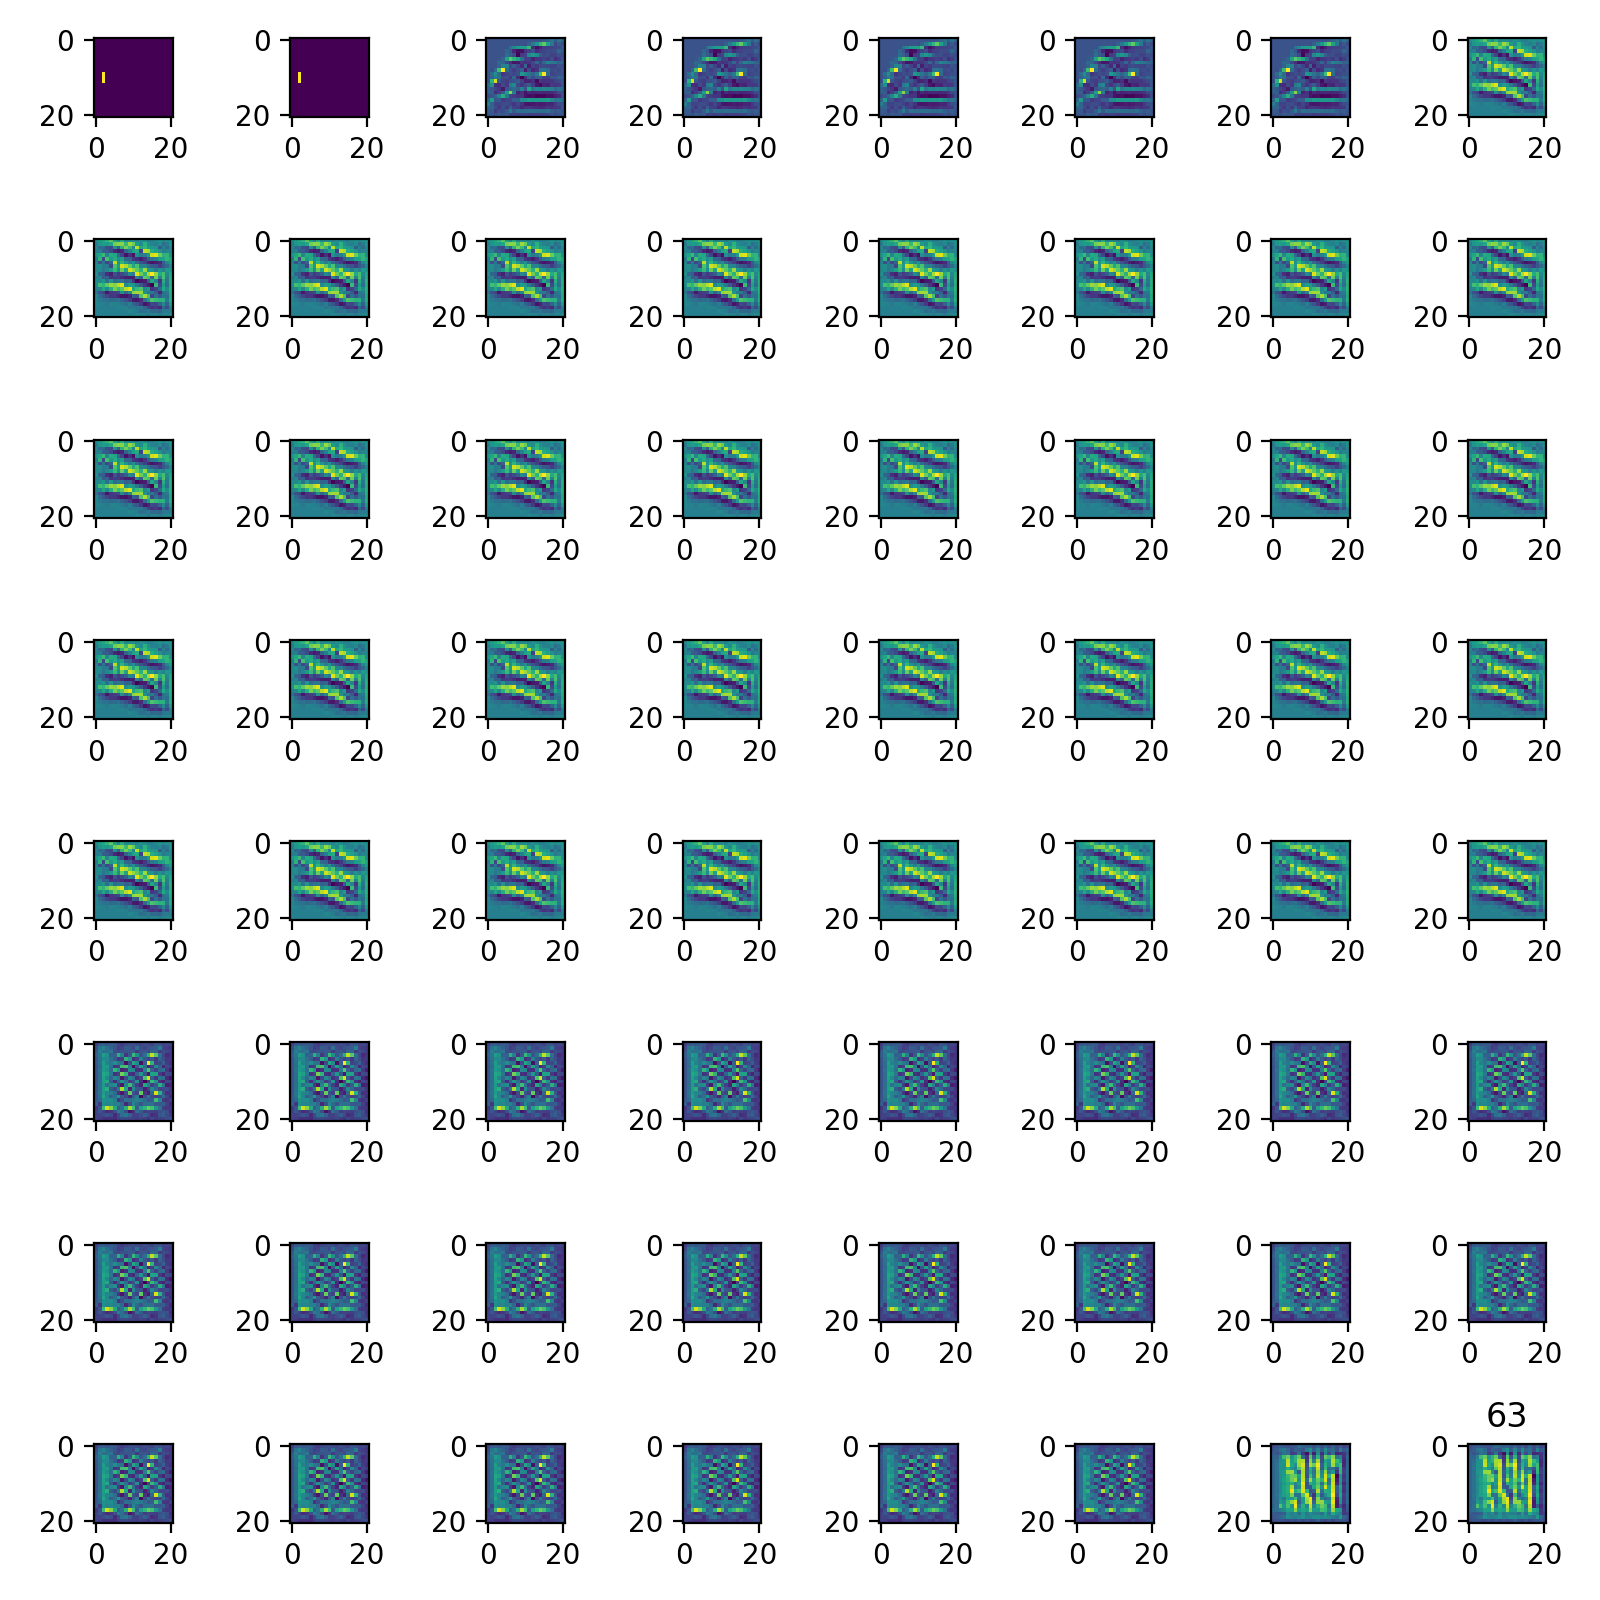

In [115]:
plot_activations(input_img_data)

---

---